### Recordatorio:
- Debes ejecutar la siguiente celda para poder jugar con lo que tenemos preparado
- Para ejecutar una celda la tienes que seleccionar y pulsar: Ctrl + Enter (Shift + Enter también vale)
- Cuando la hayas ejecutado, para iniciar el modo presentación teclea: alt + R
- Con las teclas de AvPág y RePág, adelantas o retrocedes en la presentación
- En Chrome puedes habilitar el modo a pantalla completa con: F11
- Para salir del modo presentación vuelve a teclear: alt + R

In [ ]:
#@title Módulos (o librerías, o paquetes) que hay que cargar previamente
# Si no ejecutas esta celda no vas a poder interactuar con las celdas que vendrán a continuación
from IPython.display import IFrame
from IPython.display import Image
from IPython.display import Audio
from IPython.display import YouTubeVideo
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:85% !important; }</style>"))
js = "<script>hoy = new Date();var eta_ms = new Date(hoy.getFullYear(), hoy.getMonth(), hoy.getDate(), 19, 13).getTime() - Date.now();var timeout = setTimeout(function(){alert('Héctor, quizá podrías dejar tranquilita ya a la gente, ¿no? Gracias :)');}, eta_ms);</script>"
display(HTML(js))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import matplotlib.mlab as ml
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import interactive
import scipy.io.wavfile as wavfile # sirve para leer ficheros WAV: https://docs.scipy.org/doc/scipy/reference/tutorial/io.html#module-scipy.io.wavfile
import scipy.signal as sig # hilbert, espectrograma, chirp
import pywt # sirve para la transformada de wavelet: pip install PyWavelets
import pandas as pd
import urllib.request
import warnings
warnings.filterwarnings('ignore')
class displayhoriz(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">{1}</div>"""
    def __init__(self, *args):
        self.args = args
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

In [ ]:
#@title Cepstrogram function
def cepstrogram(x, win, hop, fs):
    # function: C, q, t = cepstrogram(x, win, hop, fs)
    # Input:
    # x - signal in the time domain
    # win - analysis window function
    # hop - hop size
    # fs - sampling frequency, Hz
    # Output:
    # C - real cepstrum-matrix (only unique points,
    #     time across columns, quefrency across rows)
    # q - quefrency vector, s
    # t - time vector, s
    # representation of the signal as column-vector
    x = x[:]
    # determination of the signal length
    xlen = len(x)
    # determination of the window length
    wlen = len(win)
    # stft matrix size estimation and preallocation
    NUP = int(np.ceil((1+wlen)/2))      # calculate the number of unique fft points
    L = 1+int((xlen-wlen)/hop)          # calculate the number of signal frames
    C = np.zeros([NUP-1, L-1])          # preallocate the stft matrix
    # STFT (via time-localized FFT)
    for l in range(L-1):
        # windowing
        xw = x[l*hop : wlen+l*hop] * win
        # cepstrum calculation
        c = np.real(np.fft.ifft(np.log(np.abs(np.fft.fft(xw)))))
        # update of the cepstrum-matrix
        C[:, l] = c[0:NUP-1]
    # calculation of the time and quefrency vectors
    t = np.arange(wlen/2,wlen/2+(L-1)*hop,hop)/fs
    q = np.arange(0,NUP-1)/fs
    return C, q, t

# Tema 5.- Análisis Tiempo-Frecuencia

- Introducción
- Espectrograma
- Transformada de wavelet
- Análisis cepstral


## Objetivos:

- Introducir nuevos conceptos y técnicas en el análisis de señales
- Comprender el interés del análisis conjunto en frecuencia y en tiempo
- Comprender la importancia del tamaño de la ventana en la herramienta STFT
- Comprender las diferencias entre las herramientas STFT y wavelet
- Comprender el concepto del análisis cepstral y algunas aplicaciones de su uso

## Introducción

Necesidad del análisis conjunto en tiempo y en frecuencia:

- Vamos a analizar dos señales (una de ellas no estacionaria)
- Hasta ahora lo hemos hecho desde un punto de vista temporal o frecuencial, por separado
- Vamos a demostrar que no es suficiente

'Señal estacionaria:'

'Señal transitoria:'

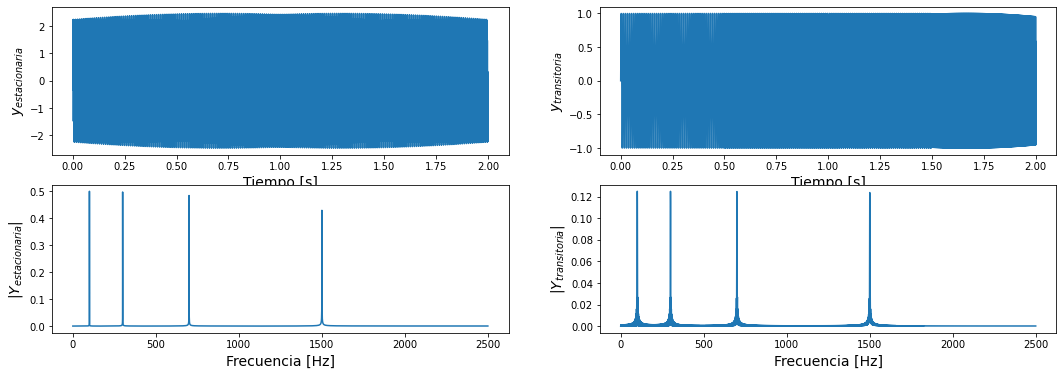

In [ ]:
#@title Señales estacionarias y transitorias
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 100, 300, 700, 1500
# Primera señal: compuesta por 4 senos simultáneos (estacionaria)
y_estac = np.sin(2 * np.pi * frec1 * t) + np.sin(2 * np.pi * frec2 * t) + np.sin(2 * np.pi * frec3 * t) + np.sin(2 * np.pi * frec4 * t)
# Segunda señal: compuesta por 4 senos consecutivos (transitoria)
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Cálculo de las transformadas de Fourier
tf_y_estac = np.fft.fft(y_estac)/N
tf_y_trans = np.fft.fft(y_trans)/N
frec = np.fft.fftfreq(N, 1/fs)
# Gráficas
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t, y_estac)
ax1.set_xlabel('Tiempo [s]', fontsize=14)
ax1.set_ylabel('$y_{estacionaria}$', fontsize=14)
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(t, y_trans)
ax2.set_xlabel('Tiempo [s]', fontsize=14)
ax2.set_ylabel('$y_{transitoria}$', fontsize=14)
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(frec[0:N//2], np.abs(tf_y_estac[0:N//2]))
ax3.set_xlabel('Frecuencia [Hz]', fontsize=14)
ax3.set_ylabel('$|Y_{estacionaria}|$', fontsize=14)
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(frec[0:N//2], np.abs(tf_y_trans[0:N//2]))
ax4.set_xlabel('Frecuencia [Hz]', fontsize=14)
ax4.set_ylabel('$|Y_{transitoria}|$', fontsize=14)
# Oigamos las señales:
display('Señal estacionaria:', Audio(y_estac, rate=fs))
display('Señal transitoria:', Audio(y_trans, rate=fs))

### Necesidad del análisis conjunto en tiempo y en frecuencia

- Pese a que hay ciertas similitudes en las gráficas en dominio tiempo y en dominio frecuencia...
- ... al escuchar las señales se percibe que no se parecen en absoluto.
- En esta ocasión el dominio tiempo va a ser la clave, porque una de las señales es transitoria (o no estacionaria)
- Se puede percibir visualmente con otras frecuencias (más bajas) manteniendo el eje de tiempos (en 2 segundos); mira:

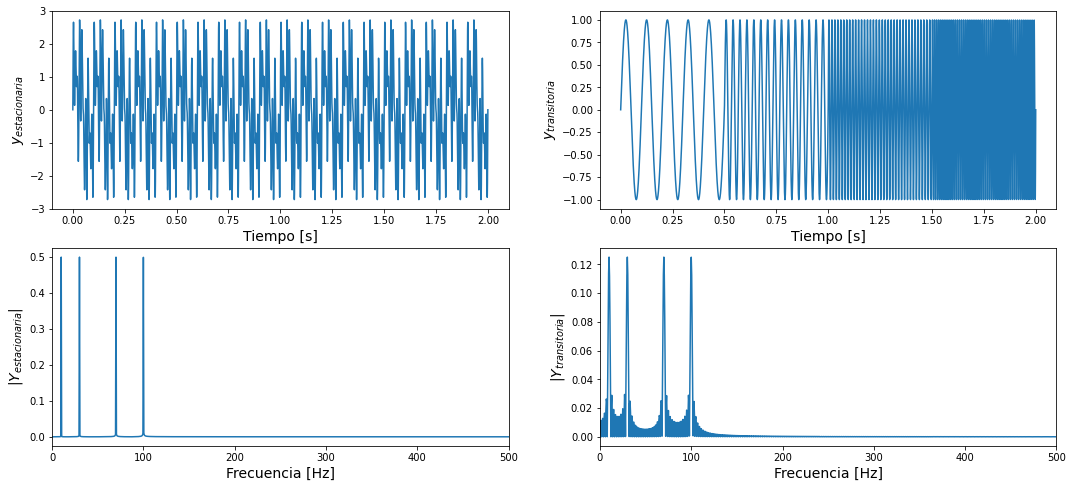

In [ ]:
#@title Señales estacionarias y transitorias: otras frecuencias para visualizarlo mejor
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 10, 30, 70, 100
# Primera señal: compuesta por 4 senos simultáneos (estacionaria)
y_estac = np.sin(2 * np.pi * frec1 * t) + np.sin(2 * np.pi * frec2 * t) + np.sin(2 * np.pi * frec3 * t) + np.sin(2 * np.pi * frec4 * t)
# Segunda señal: compuesta por 4 senos consecutivos (transitoria)
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Cálculo de las transformadas de Fourier
tf_y_estac = np.fft.fft(y_estac)/N
tf_y_trans = np.fft.fft(y_trans)/N
frec = np.fft.fftfreq(N, 1/fs)
# Gráficas
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(t, y_estac)
ax1.set_xlabel('Tiempo [s]', fontsize=14)
ax1.set_ylabel('$y_{estacionaria}$', fontsize=14)
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(t, y_trans)
ax2.set_xlabel('Tiempo [s]', fontsize=14)
ax2.set_ylabel('$y_{transitoria}$', fontsize=14)
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(frec[0:N//2], np.abs(tf_y_estac[0:N//2]))
ax3.set_xlabel('Frecuencia [Hz]', fontsize=14)
ax3.set_ylabel('$|Y_{estacionaria}|$', fontsize=14)
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(frec[0:N//2], np.abs(tf_y_trans[0:N//2]))
ax4.set_xlabel('Frecuencia [Hz]', fontsize=14)
ax4.set_ylabel('$|Y_{transitoria}|$', fontsize=14);
ax3.set_xlim(0,500)
ax4.set_xlim(0,500);

- Efectivamente, con estas frecuencias, se observa que la señal transitoria contiene 4 senos...
- ... pero que no suceden a la vez, sino uno a continuación de otro.
- En el espectro en frecuencia se pierde la información temporal y por tanto...
- ... en señales transitorias tiene mucho sentido no perder esta información.

Pero... nos gustaba tanto el dominio de la frecuencia... &#x1F614;

**¿Existirá alguna técnica donde se pueda percibir tanto la información temporal como frecuencial?**


## Espectrograma

### Short Time Fourier Transform (<a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform">STFT</a>)

- Se supone que, en una señal no estacionaria, se pueden definir fragmentos en que se puede considerar aproximadamente estacionaria y se aplica la Transformada de Fourier a cada uno de esos fragmentos
- En la práctica, se define una ventana $v$ que se va desplazando a lo largo del tiempo
$$ X \left( \tau, f \right) = \int\limits_{-\infty}^{\infty} x \left( t \right) v \left( t-\tau \right) e^{-i 2 \pi f t} \mathrm{d}t$$
- La definición de la ventana (tipo y tamaño) tiene mucha importancia como a continuación se verá

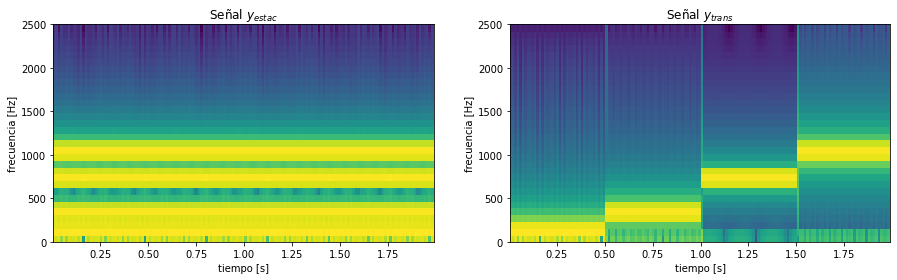

In [ ]:
#@title Creación de un espectrograma (tamaño de ventana pequeño)
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 100, 300, 700, 1000
# Primera señal: compuesta por 4 senos simultáneos (estacionaria)
y_estac = np.sin(2 * np.pi * frec1 * t) + np.sin(2 * np.pi * frec2 * t) + np.sin(2 * np.pi * frec3 * t) + np.sin(2 * np.pi * frec4 * t)
# Segunda señal: compuesta por 4 senos consecutivos (transitoria)
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Gráficas:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
tamanyo_ventana = 64
solape_ventana = 0
f1, t1, Sxx1 = sig.spectrogram(y_estac, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax1.pcolormesh(t1, f1, Sxx1)
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax2.pcolormesh(t2, f2, Sxx2)
ax1.set_title('Señal $y_{estac}$')
ax1.set_xlabel('tiempo [s]')
ax1.set_ylabel('frecuencia [Hz]')
ax2.set_title('Señal $y_{trans}$')
ax2.set_xlabel('tiempo [s]')
ax2.set_ylabel('frecuencia [Hz]');

### Explicación de un espectrograma

- Es una gráfica en la que se visualizan tres dimensiones:
    - El **tiempo** y la **frecuencia** en los ejes horizontal y vertical respectivamente (dependiendo del software que se use puede variar esta configuración)
    - La **amplitud** se muestra en forma de mapa de color (también hay muchos tipos de mapas de color; por lo general se escoge uno de forma que haya un color llamativo para los valores altos de la amplitud y un color apagado para los valores bajos)
    - En la mayoría de los casos estaremos interesados en ver la evolución temporal del color llamativo (valores altos de la amplitud de la señal, que se da a ciertas frecuencias) 

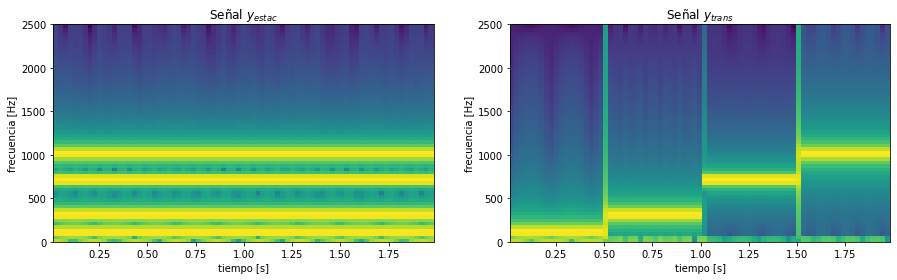

In [ ]:
#@title Aplicación: ventana intermedia
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
tamanyo_ventana = 128
solape_ventana = 0
f1, t1, Sxx1 = sig.spectrogram(y_estac, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax1.pcolormesh(t1, f1, Sxx1)
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax2.pcolormesh(t2, f2, Sxx2)
ax1.set_title('Señal $y_{estac}$')
ax1.set_xlabel('tiempo [s]')
ax1.set_ylabel('frecuencia [Hz]')
ax2.set_title('Señal $y_{trans}$')
ax2.set_xlabel('tiempo [s]')
ax2.set_ylabel('frecuencia [Hz]');

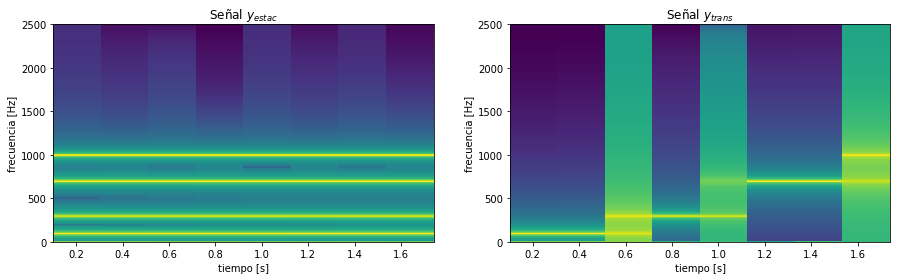

In [ ]:
#@title Aplicación: ventana grande
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
tamanyo_ventana = 1024
solape_ventana = 0
f1, t1, Sxx1 = sig.spectrogram(y_estac, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax1.pcolormesh(t1, f1, Sxx1)
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax2.pcolormesh(t2, f2, Sxx2)
ax1.set_title('Señal $y_{estac}$')
ax1.set_xlabel('tiempo [s]')
ax1.set_ylabel('frecuencia [Hz]')
ax2.set_title('Señal $y_{trans}$')
ax2.set_xlabel('tiempo [s]')
ax2.set_ylabel('frecuencia [Hz]');

### Conclusiones

- Realizar un espectrograma de una señal estacionaria no proporciona más información que su espectro en frecuencia
- Realizar un espectrograma de una señal transitoria tiene sentido: hay información de la amplitud de la señal (en escala de colores) tanto en el tiempo (en un eje, generalmente X) como en la frecuencia (en el otro eje, generalmente Y)
- La elección del tamaño de la ventana que recorre el eje temporal es fundamental para cuantificar las frecuencias relevantes y cuándo suceden
- Existe un compromiso en la elección del tamaño:
    - Ventanas pequeñas: detectan bien los cambios de la señal con el tiempo pero, al ser pequeña, la señal contiene poca información y por tanto es difícil que detecten las frecuencias con precisión
    - Ventanas grandes: sucede lo contrario; al ser grande, la señal contiene mucha información y por tanto es fácil ser preciso detectando las frecuencias; sin embargo no detectan bien los cambios de la señal con el tiempo

### Sobre las ventanas

- ¿Por qué crees que muchas de las [ventanas](https://en.wikipedia.org/wiki/Window_function) empiezan y acaban en cero? ¿Recuerdas el fenómeno de fugas?
- El tipo de ventana (rectangular, Hann,...) también influye (aunque en señales acústicas su importancia es limitada y es más decisivo elegir bien el tamaño de la misma)
- Si la ventana es grande (para tener precisión identificando frecuencias), se puede mejorar la resolución temporal incorporando un solape entre ventanas (overlap)

<img src="https://hcliment.webs.upv.es/docencia/dar/figs/tema05/espectrograma.jpg" style="float:center;width:100%;padding:1%;">

<small>Fuente: <a href="https://inst.eecs.berkeley.edu/~ee123/sp17/lab/lab3/lab3-Part_I_Time-Frequency-Spectrogram.html">https://inst.eecs.berkeley.edu/~ee123/sp17/lab/lab3/lab3-Part_I_Time-Frequency-Spectrogram.html</a></small>



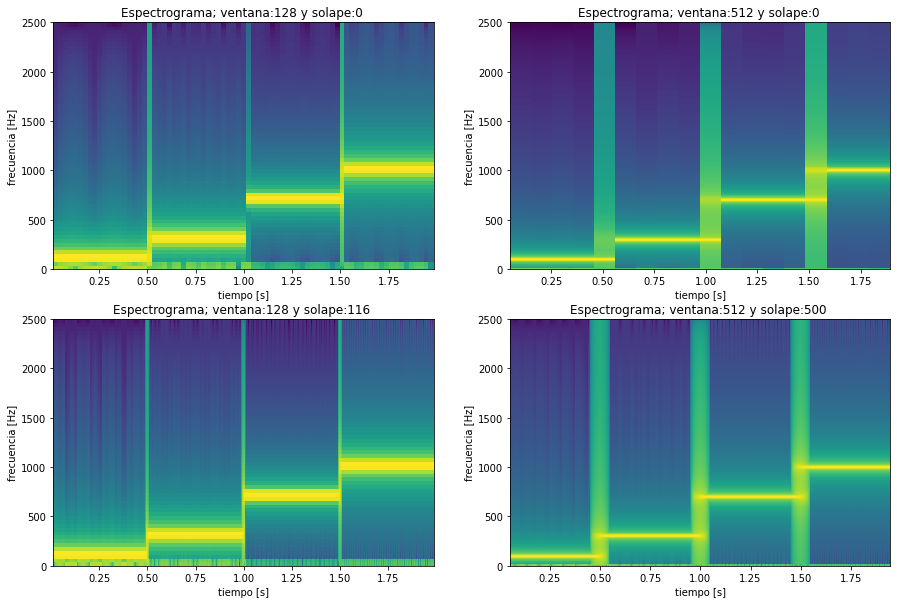

In [ ]:
#@title Comparación de tamaños de ventana y solape
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 100, 300, 700, 1000
# Señal transitoria compuesta por 4 senos consecutivos
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Gráficas:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
tamanyo_ventana1, solape_ventana1 = 128, 0
tamanyo_ventana2, solape_ventana2 = 512, 0
tamanyo_ventana3, solape_ventana3 = 128, 116
tamanyo_ventana4, solape_ventana4 = 512, 500
f1, t1, Sxx1 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana1), noverlap=solape_ventana1)
ax1.pcolormesh(t1, f1, np.log10(Sxx1))
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana2), noverlap=solape_ventana2)
ax2.pcolormesh(t2, f2, np.log10(Sxx2))
f3, t3, Sxx3 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana3), noverlap=solape_ventana3)
ax3.pcolormesh(t3, f3, np.log10(Sxx3))
f4, t4, Sxx4 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana4), noverlap=solape_ventana4)
ax4.pcolormesh(t4, f4, np.log10(Sxx4))
def tunea_figura(eje, titulo, ejex, ejey):
    eje.set_title(titulo)
    eje.set_xlabel(ejex)
    eje.set_ylabel(ejey)
tunea_figura(ax1,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana1, solape_ventana1), 'tiempo [s]', 'frecuencia [Hz]')
tunea_figura(ax2,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana2, solape_ventana2), 'tiempo [s]', 'frecuencia [Hz]')
tunea_figura(ax3,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana3, solape_ventana3), 'tiempo [s]', 'frecuencia [Hz]')
tunea_figura(ax4,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana4, solape_ventana4), 'tiempo [s]', 'frecuencia [Hz]')


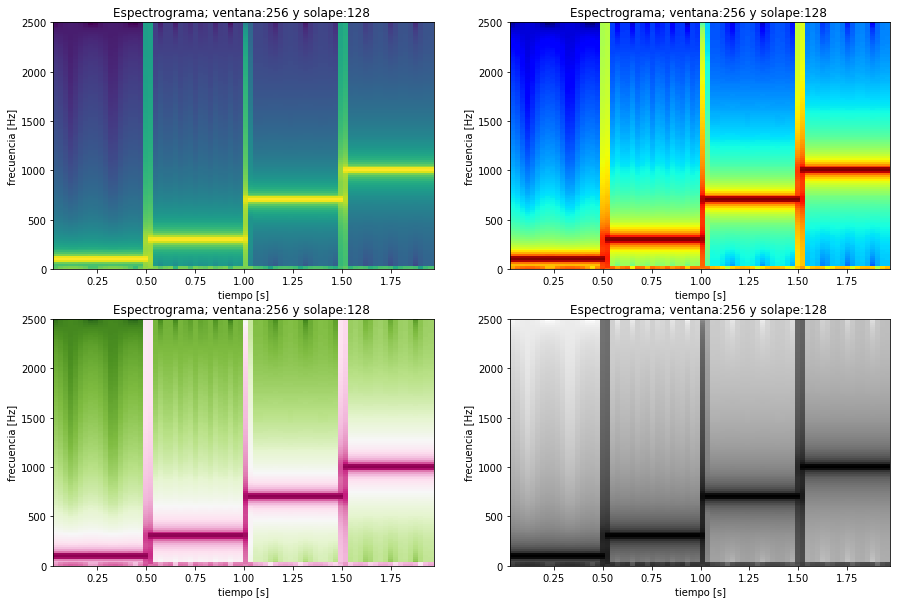

In [ ]:
#@title Estética: comparación de mapas de color
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 100, 300, 700, 1000
# Señal transitoria compuesta por 4 senos consecutivos
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Gráficas:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
tamanyo_ventana1, solape_ventana1 = 256,128
tamanyo_ventana2, solape_ventana2 = 256,128
tamanyo_ventana3, solape_ventana3 = 256,128
tamanyo_ventana4, solape_ventana4 = 256,128
f1, t1, Sxx1 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana1), noverlap=solape_ventana1)
ax1.pcolormesh(t1, f1, np.log10(Sxx1),cmap='viridis')
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana2), noverlap=solape_ventana2)
ax2.pcolormesh(t2, f2, np.log10(Sxx2),cmap='jet')
f3, t3, Sxx3 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana3), noverlap=solape_ventana3)
ax3.pcolormesh(t3, f3, np.log10(Sxx3),cmap='PiYG_r')
f4, t4, Sxx4 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana4), noverlap=solape_ventana4)
ax4.pcolormesh(t4, f4, np.log10(Sxx4),cmap='gray_r')
def tunea_figura(eje, titulo, ejex, ejey):
    eje.set_title(titulo)
    eje.set_xlabel(ejex)
    eje.set_ylabel(ejey)
tunea_figura(ax1,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana1, solape_ventana1), 'tiempo [s]', 'frecuencia [Hz]')
tunea_figura(ax2,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana2, solape_ventana2), 'tiempo [s]', 'frecuencia [Hz]')
tunea_figura(ax3,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana3, solape_ventana3), 'tiempo [s]', 'frecuencia [Hz]')
tunea_figura(ax4,'Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana4, solape_ventana4), 'tiempo [s]', 'frecuencia [Hz]')


Puede ser un buen momento para hacer el ejercicio 5.1

## Transformada wavelet

- La transformada de Fourier está bien, pero ¿te has preguntado por qué buscamos parecidos entre nuestra señal y una familia de senos de diferente tamaño (amplitud) y duración (frecuencia)? ¿Es que no podríamos buscar parecidos entre nuestra señal y otro tipo de funciones?
- Definición matemática:
$$ CWT_x^\psi \left( \tau, s \right) = \Psi_x^\psi \left( \tau, s \right) = \frac{1}{\sqrt{s}} \int\limits_{-\infty}^{\infty} x \left( t \right) \psi^* \left( \frac{t-\tau}{s} \right) \mathrm{d}t$$
siendo $\tau$ la traslación, $\psi$ la función wavelet madre, y $s$ la escala (inversa de la frecuencia)

<img src="https://hcliment.webs.upv.es/docencia/dar/figs/tema05/wavelet.jpg" style="float:center;width:100%;padding:1%;">


### Características
- Estamos interesados en la Transformada Wavelet Continua (<a href="https://en.wikipedia.org/wiki/Wavelet">CWT</a>)
- Es una transformación similar a la STFT pero:
    - Hay que elegir una función (wavelet) que queramos desplazar a lo largo de nuestra señal para detectar parecidos con ella
    - Por tanto, no se hacen las transformadas de Fourier de las señales enventanadas
    - La duración (anchura) de la ventana se ve modificada cuando se cambia la escala de la wavelet. Esto conduce a que al evaluar escalas más pequeñas de la wavelet, la anchura de la ventana es menor en alta frecuencia

<img src="https://hcliment.webs.upv.es/docencia/dar/figs/tema05/STFTvsWavelet.jpg" style="float:center;width:100%;padding:1%;">

<small>Fuente: <a href="https://commons.wikimedia.org/wiki/File:STFT_and_WT.jpg">https://commons.wikimedia.org/wiki/File:STFT_and_WT.jpg</a></small>


###Ejemplos de wavelets madre

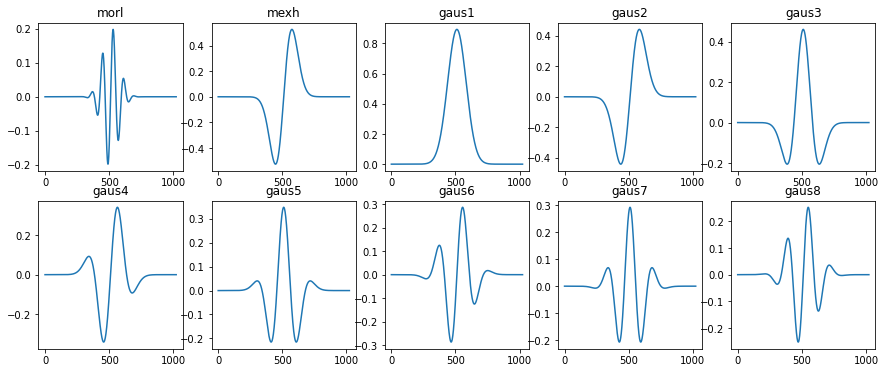

In [ ]:
#@title Wavelets más utilizadas (lista incompleta)
# En esta celda se muestran algunas familias de wavelets que hay en el paquete pywt
# pywt.wavelist(kind='continuous') # para sacar el listado completo de CWT
tipos = ['morl', 'mexh', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8']
fig = plt.figure(figsize=(15, 6))
cont = 0
for tipo in tipos:
    wav = pywt.ContinuousWavelet(tipo)
    cont = cont + 1
    eje = fig.add_subplot(2, 5, cont)
    int_psi, x = pywt.integrate_wavelet(wav, precision=10)
    eje.plot(int_psi)
    eje.set_title(tipo)

Se recomienda probar diferentes familias de wavelets para ver su influencia en el problema que se está analizando. En ocasiones, en función de la naturaleza del ruido, esto puede ser importante. En otras ocasiones, no.

Vamos a trabajar ahora en el notebook. Abandona el modo presentación (Alt+R).


## Aplicación: Comparación entre espectrograma y wavelet

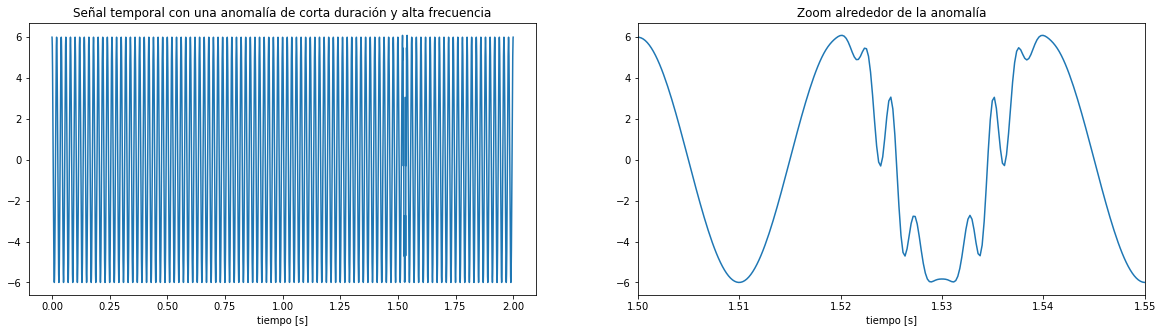

In [ ]:
#@title Ejemplo de una señal peculiar
# Creación de una señal temporal  consistente en: un seno de baja frecuencia y un transitorio corto a alta frecuencia
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
y_trans = 6 * np.cos(2 * np.pi * 50 * t) + 3 * sig.gausspulse(t-1.525, fc=400) + 3 * sig.gausspulse(t-1.535, fc=400)
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t,y_trans)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(t,y_trans)
ax2.set_xlim(1.5,1.55)
ax1.set_title('Señal temporal con una anomalía de corta duración y alta frecuencia')
ax1.set_xlabel('tiempo [s]')
ax2.set_title('Zoom alrededor de la anomalía')
ax2.set_xlabel('tiempo [s]')
# A ver cómo suena:
Audio(y_trans, rate=fs)

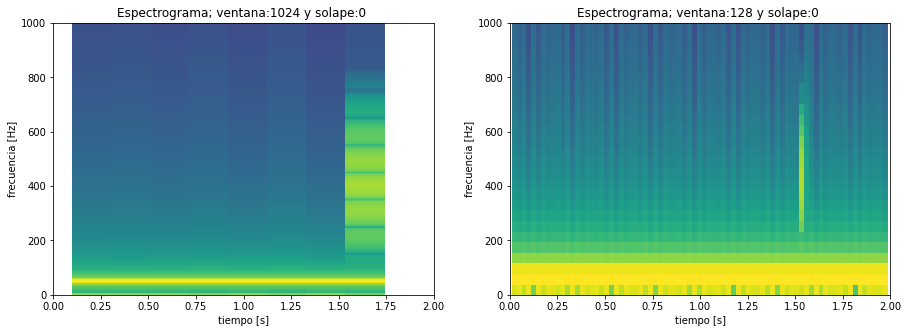

In [ ]:
#@title Análisis usando el espectrograma
# Intentemos analizarla con el espectrograma: usando dos tamaños de ventanas
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
y_trans = 6 * np.cos(2 * np.pi * 50 * t) + 3 * sig.gausspulse(t-1.525, fc=400) + 3 * sig.gausspulse(t-1.535, fc=400)
# Gráficas:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
tamanyo_ventana1 = 1024
tamanyo_ventana2 = 128
solape_ventana1 = 0
solape_ventana2 = 0
f1, t1, Sxx1 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana1), noverlap=solape_ventana1)
ax1.pcolormesh(t1, f1, Sxx1)
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana2), noverlap=solape_ventana2)
ax2.pcolormesh(t2, f2, Sxx2)

ax1.set_title('Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana1, solape_ventana1))
ax2.set_title('Espectrograma; ventana:{} y solape:{} '.format(tamanyo_ventana2, solape_ventana2))
for ax in [ax1, ax2]:
    ax.set_ylim(0, 1000)
    ax.set_xlim(0, 2)
    ax.set_xlabel('tiempo [s]')
    ax.set_ylabel('frecuencia [Hz]')
    

**Análisis**

- Un tamaño de ventana grande detectará muy bien la parte estacionaria de la señal pero no la parte transitoria
- Con un tamaño de ventana pequeño sucederá todo lo contrario
- Es muy difícil encontrar un compromiso acertado con el tamaño de la ventana en esta señal en particular

Por si quieres corregir el vector de escalas: Frecuencias mínima (30.0 Hz) y máxima (999.9999999999999 Hz)


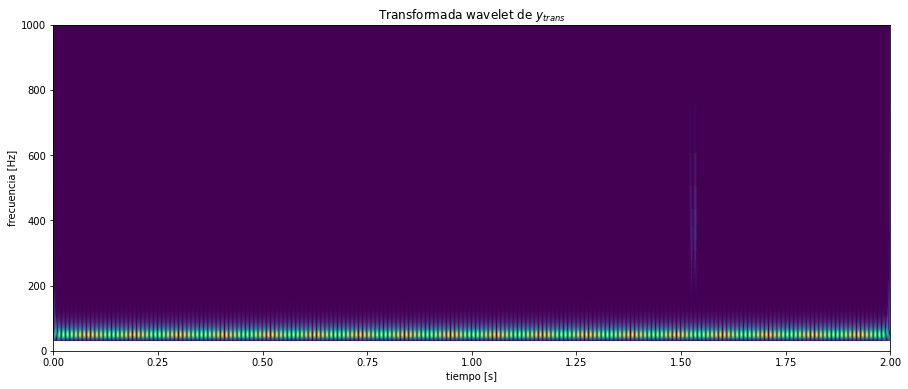

In [ ]:
#@title Análisis usando la transformada de wavelet
# Esta celda sirve para hacer una transformada wavelet
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
y_trans = 6 * np.cos(2 * np.pi * 50 * t) + 3 * sig.gausspulse(t-1.525, fc=400) + 3 * sig.gausspulse(t-1.535, fc=400)
# Transformada de wavelet
escalas = np.linspace(3,100,100)
tipowavelet = 'gaus7'
aux_cwt_trans = pywt.cwt(y_trans, escalas, tipowavelet, 1/fs)
cwt_trans = aux_cwt_trans[0]
frecs = aux_cwt_trans[1]
# Gráfica:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 1, 1)
X, Y = np.meshgrid(t, frecs)
im = ax1.pcolormesh(X, Y, np.abs(cwt_trans))
#fig.colorbar(im, ax=ax1)
ax1.set_title('Transformada wavelet de $y_{trans}$')
ax1.set_xlabel('tiempo [s]')
ax1.set_ylabel('frecuencia [Hz]')
ax1.set_ylim(0, 1000)
print('Por si quieres corregir el vector de escalas: Frecuencias mínima ({} Hz) y máxima ({} Hz)'.format(frecs.min(), frecs.max()))

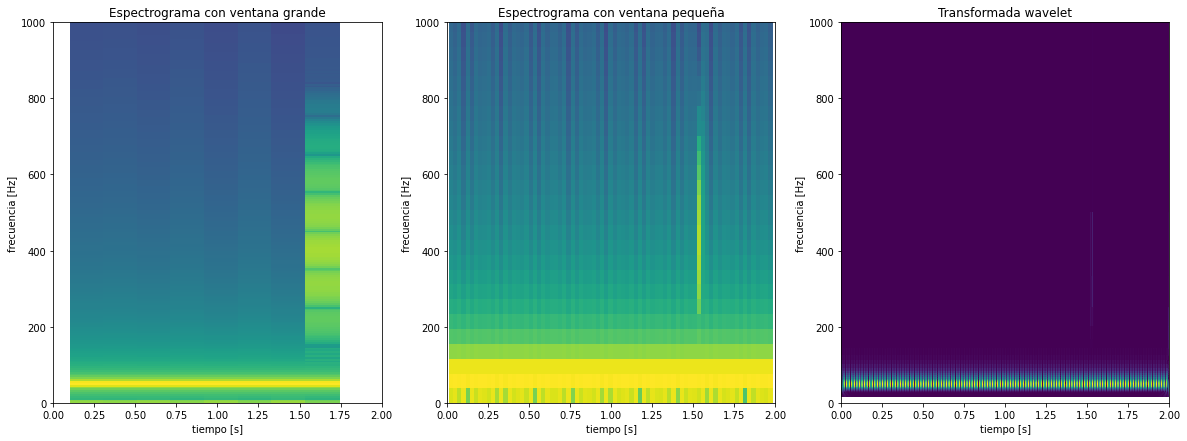

In [ ]:
#@title Comparación de ambas técnicas
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
y_trans = 6 * np.cos(2 * np.pi * 50 * t) + 3 * sig.gausspulse(t-1.525, fc=400) + 3 * sig.gausspulse(t-1.535, fc=400)
# Transformada de wavelet
escalas = np.linspace(3,300,100)
tipowavelet = 'gaus7'
aux_cwt_trans = pywt.cwt(y_trans, escalas, tipowavelet, 1/fs)
cwt_trans = aux_cwt_trans[0]
frecs = aux_cwt_trans[1]
# Gráficas:
fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
tamanyo_ventana1 = 1024
tamanyo_ventana2 = 128
solape_ventana1 = 0
solape_ventana2 = 0
f1, t1, Sxx1 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana1), noverlap=solape_ventana1)
ax1.pcolormesh(t1, f1, Sxx1)
f2, t2, Sxx2 = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana2), noverlap=solape_ventana2)
ax2.pcolormesh(t2, f2, Sxx2)
X, Y = np.meshgrid(t, frecs)
im = ax3.pcolormesh(X, Y, np.abs(cwt_trans))
#fig.colorbar(im, ax=ax1)
ax1.set_title('Espectrograma con ventana grande')
ax2.set_title('Espectrograma con ventana pequeña')
ax3.set_title('Transformada wavelet')
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0, 1000)
    ax.set_xlim(0, 2)
    ax.set_xlabel('tiempo [s]')
    ax.set_ylabel('frecuencia [Hz]')
    

**Análisis**

- El espectrograma con un tamaño de ventana grande detecta muy bien la parte estacionaria de la señal (seno a 50 Hz de principio a fin) pero no ubica bien temporalmente la parte transitoria
- El espectrograma con un tamaño de ventana pequeño detecta muy bien la parte transitoria de la señal (alrededor de 1.5 segundos) pero no es muy preciso detectando las bajas frecuencia (no sabemos cómo se está comportando nuestra señal entre los 30 y los 130 Hz porque hay una banda amarilla enorme en esa zona)
- Sin embargo, en este caso, la transformada de wavelet proporciona los resultados deseados: es muy precisa detectando que hay un seno a 50 Hz a lo largo de toda la señal, y también que alrededor de 1.5 segundos sucede un evento de más alta frecuencia


Puede ser un buen momento para hacer el ejercicio 5.2

## Análisis cepstral

Concepto de (<a href="https://en.wikipedia.org/wiki/Cepstrum">cepstro</a>)

- Definición: El cepstro de una señal es el resultado de calcular la transformada inversa de Fourier del espectro de la señal estudiada en escala logarítmica. Fácil, ¿no? &#x1F605;
- Definición matemática:
$$ \hat{x}[\tau] = F^{-1} \left[ \ln F[x(t)] \right] = F^{-1} \left[ \ln X(f) \right]$$
- Interés: permite intentar separar la parte de la respuesta de un sistema que es característica de éste ($h$) de la parte que corresponde a la excitación que la produce ($x$), a partir de la medida de la respuesta ($y$):
    - Análisis en tiempo: producto de convolución: $y(t) = h(t) * x(t)$
    - Análisis en frecuencia: producto: $Y(f) = H(f) \cdot X(f)$
    - Análisis cepstral: suma: $\hat{y}(\tau) = \hat{h}(\tau) + \hat{x}(\tau)$


- Demostración:
    - Tomando logaritmos en el dominio en frecuencia:
$$ \ln Y(f) = \ln \left[ H(f) \cdot X(f) \right] = \ln H(f) + \ln X(f) $$
    - Y definiendo el cepstro como la transformada de Fourier inversa de lo anterior:
$$ 
\begin{align}
\hat{y}(\tau) & = F^{-1} \left[ \ln Y(f) \right] \\
 & = F^{-1} \left[ \ln H(f) + \ln X(f) \right] \\
 & = F^{-1} \left[ \ln H(f) \right] + F^{-1} \left[ \ln X(f) \right] \\
 & = \hat{h}(\tau) + \hat{x}(\tau)
\end{align}
$$

- Aplicaciones:
    - Detección de separación de frecuencias en el espectro
    - Cancelación de ecos: al estar separadas las características de la fuente (source, $x(t)$) y la propagación (path, $h(t)$) y poder modificar (sustraer, filtrar) partes del cepstro
    - Reconocimiento del habla (un poco alejado de esta asignatura)

In [ ]:
#@title Aplicación del análisis cepstral: cancelación del eco
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema05/signalconeco.dat') # descarga el fichero de Internet
with open('signalconeco.dat','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
dat = pd.read_csv('signalconeco.dat', skiprows=0, skipfooter=0, sep='\t', dtype=float, engine='python')
# Mostremos las 5 primeras filas del objeto donde hemos guardado el contenido del fichero
dat.head(5)

,tiempo,valor
0,0.0000,0.001245
1,0.0002,0.001494
2,0.0004,0.001992
3,0.0006,0.002241
4,0.0008,0.002490


'Señal con eco:'

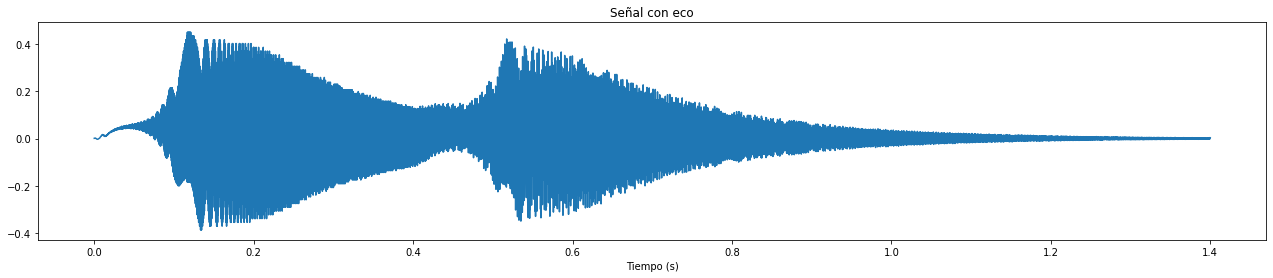

In [ ]:
#@title Visualización de la señal con eco
t = dat['tiempo'].values
h = dat['valor'].values
num=len(h)
fs=1/(t[1]-t[0])
fig = plt.figure(figsize=(22, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(t,h)
ax1.set_xlabel('Tiempo (s)'), ax1.set_title('Señal con eco')
display('Señal con eco:', Audio(h, rate=fs))

**Análisis**

- A partir de la gráfica: intenta averiguar el tiempo que tarda el eco en llegar
- Obtengamos ese delay del eco de forma más profesional: autocorrelación (esto aprendiste a hacerlo en el tema 4)

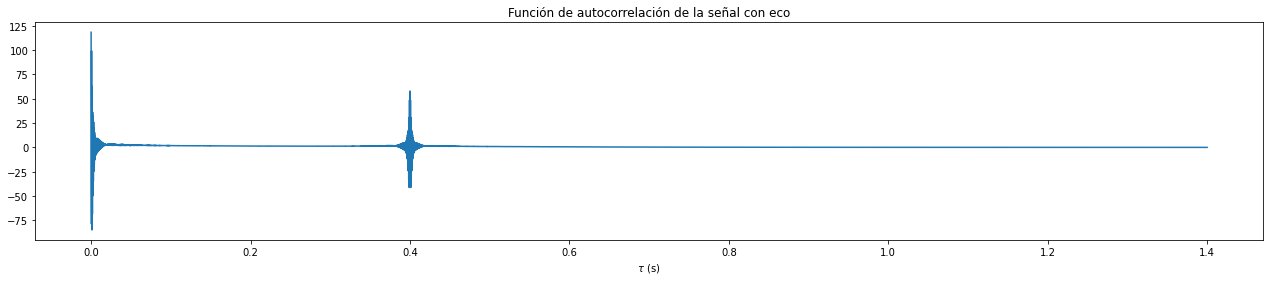

In [ ]:
#@title Autocorrelación de una señal con eco
hc = np.correlate(h, h, 'full')
# Graficamos la función de autocorrelación:
fig = plt.figure(figsize=(22, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(t,hc[num-1:]) # fíjate que solo representamos la rama de la derecha de hc
ax1.set_xlabel(r'$\tau$ (s)'), ax1.set_title('Función de autocorrelación de la señal con eco');


¿Acertaste con el retraso del eco?

In [ ]:
#@title Funciones relacionadas con el cepstro (ejecuta esta celda)
# Estas funciones nos servirán para calcular el cepstro y su inversa
# Fuente: http://python-acoustics.github.io/python-acoustics/_modules/acoustics/cepstrum.html

def complex_cepstrum(x, n=None):
    r"""Compute the complex cepstrum of a real sequence.
    """
    def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples + 1) // 2
        if samples == 1:
            center = 0
        ndelay = np.array(np.round(unwrapped[..., center] / np.pi))
        unwrapped -= np.pi * ndelay[..., None] * np.arange(samples) / center
        return unwrapped, ndelay

    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)) + 1j * unwrapped_phase
    ceps = np.fft.ifft(log_spectrum).real
    return ceps, ndelay

def inverse_complex_cepstrum(ceps, ndelay):
    r"""Compute the inverse complex cepstrum of a real sequence.
    """
    def _wrap(phase, ndelay):
        ndelay = np.array(ndelay)
        samples = phase.shape[-1]
        center = (samples + 1) // 2
        wrapped = phase + np.pi * ndelay[..., None] * np.arange(samples) / center
        return wrapped

    log_spectrum = np.fft.fft(ceps)
    spectrum = np.exp(log_spectrum.real + 1j * _wrap(log_spectrum.imag, ndelay))
    x = np.fft.ifft(spectrum).real
    return x

def real_cepstrum(x, n=None):
    r"""Compute the real cepstrum of a real sequence.
    """
    spectrum = np.fft.fft(x, n=n)
    ceps = np.fft.ifft(np.log(np.abs(spectrum))).real

    return ceps

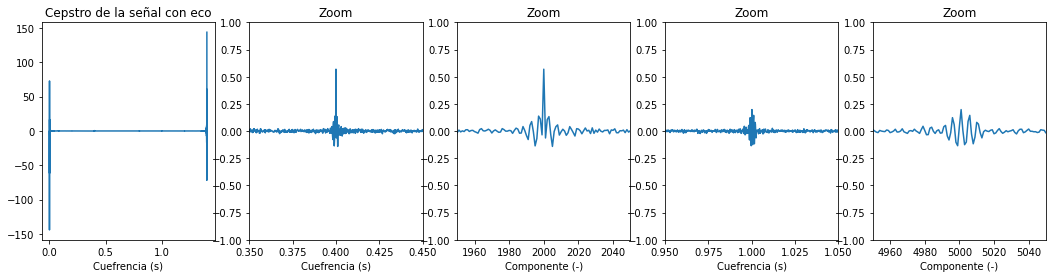

In [ ]:
#@title
# Bien, vamos a tratar de eliminar el eco de nuestra señal
# Calculemos el cepstro complejo:
hhat, nd = complex_cepstrum(h)
# Grafiquemos:
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 5, 1)
ax1.plot(t,hhat)
ax1.set_xlabel('Cuefrencia (s)'), ax1.set_title('Cepstro de la señal con eco')
# Miramos qué sucede en torno a 0.4 segundos de cuefrencia:
ax2 = fig.add_subplot(1, 5, 2)
ax2.plot(t,hhat)
ax2.set_xlim([0.35,0.45]), ax2.set_ylim([-1,1])
ax2.set_xlabel('Cuefrencia (s)'), ax2.set_title('Zoom')
# No sorprende, ¿no?
ax3 = fig.add_subplot(1, 5, 3)
ax3.plot(hhat)
ax3.set_xlim([1950,2050]), ax3.set_ylim([-1,1])
ax3.set_xlabel('Componente (-)'), ax3.set_title('Zoom')
# Miramos también en la parte simétrica:
ax4 = fig.add_subplot(1, 5, 4)
ax4.plot(t,hhat)
ax4.set_xlim([0.95,1.05]), ax4.set_ylim([-1,1])
ax4.set_xlabel('Cuefrencia (s)'), ax4.set_title('Zoom')
# No sorprende, ¿no?
ax5 = fig.add_subplot(1, 5, 5)
ax5.plot(hhat)
ax5.set_xlim([4950,5050]), ax5.set_ylim([-1,1])
ax5.set_xlabel('Componente (-)'), ax5.set_title('Zoom');

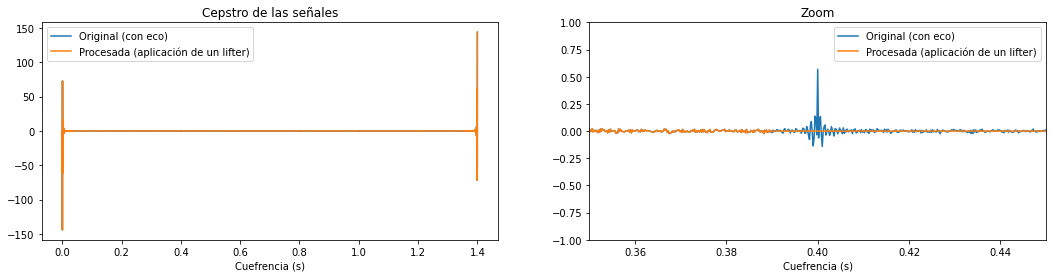

In [ ]:
#@title Aplicando un "lifter" (filtrando un cepstro)
# Vamos a usar variables auxiliares (2) para no modificar las originales
h2hat, nd2 = complex_cepstrum(h)
# Eliminamos componentes alrededor de donde encontramos la información del eco
# (en realidad estamos aplicando un filtro ('lifter', de 'filter' al revés) muy simple
# que consiste en poner a cero todo lo que hay en el cepstro más allá de la cuefrencia de 0.39 s)
h2hat[1950:5050] = np.zeros([len(hhat[1950:5050])])
# Grafiquemos:
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(t, hhat, label='Original (con eco)')
ax1.plot(t, h2hat, label='Procesada (aplicación de un lifter)')
ax1.set_xlabel('Cuefrencia (s)'), ax1.set_title('Cepstro de las señales')
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(t, hhat, label='Original (con eco)')
ax2.plot(t, h2hat, label='Procesada (aplicación de un lifter)')
ax2.set_xlim([0.35,0.45]), ax2.set_ylim([-1,1])
ax2.set_xlabel('Cuefrencia (s)'), ax2.set_title('Zoom')
ax1.legend()
ax2.legend();

'Señal con eco:'

'Señal sin eco:'

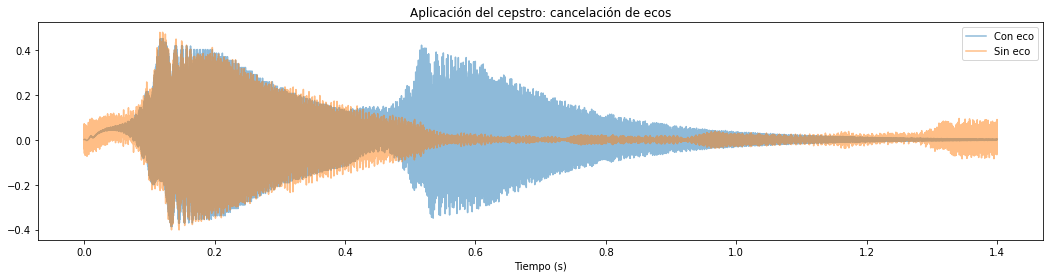

In [ ]:
#@title Cancelación del eco
# Reconstruimos la señal aplicando la inversa del cepstro:
hsin = inverse_complex_cepstrum(h2hat,nd2);
# Comparamos las señales original (con eco) y la procesada (sin eco):
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(t, h, alpha=0.5, label='Con eco')
ax1.plot(t, hsin, alpha=0.5, label='Sin eco')
ax1.legend()
ax1.set_xlabel('Tiempo (s)'), ax1.set_title('Aplicación del cepstro: cancelación de ecos')
display('Señal con eco:', Audio(h, rate=fs))
display('Señal sin eco:', Audio(hsin, rate=fs))

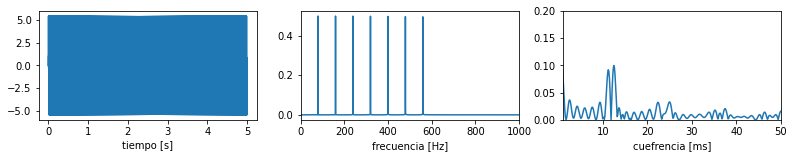

In [ ]:
#@title Aplicación del cepstro: detección de frecuencias equiespaciadas en el espectro
tmax = 5.0
fs = 8000.0
N = int(fs*tmax)
t = np.linspace(0, tmax, N)
fundamental = 80.0
harmonics = np.arange(1, 8) * fundamental
senyal = np.sin(2.0*np.pi*harmonics[:,None]*t).sum(axis=0)
tf_senyal = np.fft.fft(senyal)/N
frec = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

cepsR = real_cepstrum(senyal)
fig = plt.figure(figsize=(18, 2))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(t, senyal)
ax1.set_xlabel('tiempo [s]')
#ax1.set_xlim(0.0, 0.05)
ax2 = fig.add_subplot(1,3,2)
ax2.plot(frec[:Nmitad], np.abs(tf_senyal[:Nmitad]))
ax2.set_xlabel('frecuencia [Hz]')
ax2.set_xlim(0.0, 1000)
ax3 = fig.add_subplot(1,3,3)
ax3.plot(t*1000, np.abs(cepsR))
ax3.set_xlabel('cuefrencia [ms]')
ax3.set_xlim(1, 50)
ax3.set_ylim(0, 0.2)
# A ver cómo suena:
Audio(senyal, rate=fs)

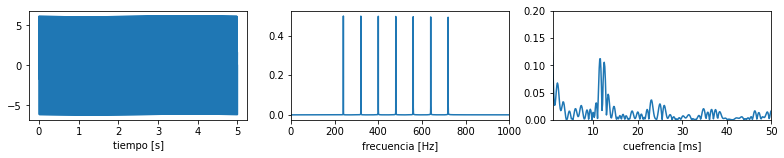

In [ ]:
#@title
# Caso práctico de aplicación del cepstro: detección de frecuencias equiespaciadas
tmax = 5.0
fs = 8000.0
N = int(fs*tmax)
t = np.linspace(0, tmax, N)
fundamental = 80.0
harmonics = np.arange(3, 10) * fundamental
senyal = np.sin(2.0*np.pi*harmonics[:,None]*t).sum(axis=0)
tf_senyal = np.fft.fft(senyal)/N
frec = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

cepsR = real_cepstrum(senyal)
fig = plt.figure(figsize=(18, 2))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(t, senyal)
ax1.set_xlabel('tiempo [s]')
#ax1.set_xlim(0.0, 0.05)
ax2 = fig.add_subplot(1,3,2)
ax2.plot(frec[:Nmitad], np.abs(tf_senyal[:Nmitad]))
ax2.set_xlabel('frecuencia [Hz]')
ax2.set_xlim(0.0, 1000)
ax3 = fig.add_subplot(1,3,3)
ax3.plot(t*1000, np.abs(cepsR))
ax3.set_xlabel('cuefrencia [ms]')
ax3.set_xlim(1, 50)
ax3.set_ylim(0, 0.2)
# A ver cómo suena:
Audio(senyal, rate=fs)

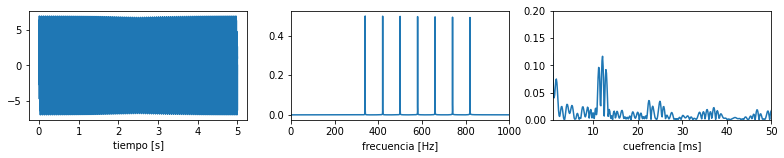

In [ ]:
#@title
# Caso práctico de aplicación del cepstro: detección de frecuencias equiespaciadas
tmax = 5.0
fs = 8000.0
N = int(fs*tmax)
t = np.linspace(0, tmax, N)
fundamental = 80.0
harmonics = np.arange(3, 10) * fundamental + 100
senyal = np.sin(2.0*np.pi*harmonics[:,None]*t).sum(axis=0)
tf_senyal = np.fft.fft(senyal)/N
frec = np.fft.fftfreq(N, 1/fs)
Nmitad = N//2 if N%2==0 else N//2+1

cepsR = real_cepstrum(senyal)
fig = plt.figure(figsize=(18, 2))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(t, senyal)
ax1.set_xlabel('tiempo [s]')
#ax1.set_xlim(0.0, 0.05)
ax2 = fig.add_subplot(1,3,2)
ax2.plot(frec[:Nmitad], np.abs(tf_senyal[:Nmitad]))
ax2.set_xlabel('frecuencia [Hz]')
ax2.set_xlim(0.0, 1000)
ax3 = fig.add_subplot(1,3,3)
ax3.plot(t*1000, np.abs(cepsR))
ax3.set_xlabel('cuefrencia [ms]')
ax3.set_xlim(1, 50)
ax3.set_ylim(0, 0.2)
# A ver cómo suena:
Audio(senyal, rate=fs)

**Análisis**

- El cepstro muestra un valor elevado alrededor de los 12.5 ms de cuefrencia
- Si convertimos este valor a frecuencia se tiene:
$$ F = \frac{1}{t} = \frac{1}{0.0125} = 80 \; Hz$$
- Esto significa que en el espectro vamos a encontrar frecuencia relevantes de la señal separadas en 80 Hz
- Conviene remarcar que el cepstro detecta periodicidades en el espectro pero no dice nada de cuáles son las frecuencias relevantes, solo da información de la separación entre ellas
- Así, una utilidad importante del cepstro es la de identificar bandas laterales en espectros. Este fenómeno se manifiesta en señales moduladas que aparecen cuando existen fallos en rodamientos como se verá en el tema siguiente

## Ejercicios

Resuelve los siguientes ejercicios en las celdas habilitadas para ello.

### Instrucciones:

Puede haber 3 tipos de celdas:

- Ya completadas: no tienes que escribir nada. Son celdas que ya tienen la solución a lo que se pregunta pero puede ser interesante ver lo que hay escrito por si te sirve para completar celdas siguientes.
- Parcialmente completadas: tienes que quitar los símbolos de comentario (#) para habilitar el código y reemplazar RELLENA-AQUI con lo que consideres oportuno.
- Vacías: tienes que escribir tú todo el código. Muchas veces se puede hacer usando de forma inteligente "copiar-pegar" de celdas anteriores o de código de celdas vistas en el tema de teoría.

### Ejercicio 5.1: Espectrograma

En un ejercicio del tema anterior se calculó la transformada de Fourier de la señal "ferrari355-freesound43484.wav" que se encuentra en la carpeta "sounds/tema04". Allí nos dimos cuenta que mucha información del espectro no servía porque nos encontrábamos con una señal transitoria. Es momento ahora de utilizar el espectrograma:

Se pide:

- Carga el fichero de audio y crea un objeto Audio para oírlo
- Haz una figura con tres gráficas:
    - En la gráfica superior muestra la evolución temporal de la señal
    - En la gráfica del medio representa su transformada de Fourier
    - En la gráfica inferior representa el espectrograma: elige el tamaño de la ventana y del solape de manera sensata y muestra las frecuencias hasta los 1000 Hz

In [ ]:
#@title Celda sin la solución; inténtalo, no vas a romper nada
##############################################################
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/ferrari355-freesound43484.wav') # descarga el fichero de Internet
with open('ferrari355-freesound43484.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Lectura de un fichero de audio (en formato WAV)
fs, senyal = wavfile.read("ferrari355-freesound43484.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
    
# Npuntos = len()
# tmax = 
# tiempo = np.linspace(, , ) # creamos también el vector de tiempos, que nos hará falta después
fig = plt.figure(figsize=(22, 10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
# Cálculo de la transformada de Fourier:
# tf_senyal = np.fft.fft()/Npuntos*2
# fr_senyal = np.fft.fftfreq(Npuntos, 1/fs)
# Nmitad = Npuntos//2 if Npuntos%2==0 else Npuntos//2+1

# Gráficas:
# ax1.plot(tiempo, senyal)
# ax1.set_xlim([0, len(senyal)/fs])
ax1.set_title('Señal temporal: Ferrari 355 (fuente: https://freesound.org/people/enginemusic/sounds/43484/)')
# ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
# ax2.set_xlim([0, 1000])
ax2.set_title('Espectro')
# Cálculo del espectrograma y graficado:
tamanyo_ventana, solape_ventana = 4096, 3000
# fA, tA, SxxA = signal.spectrogram()
# ax3.pcolormesh(tA, fA, np.log10(SxxA))
ax3.set_ylim([0, 1000])
ax3.set_title('Espectrograma')
ax3.set_xlabel('tiempo [s]')
ax3.set_ylabel('frecuencia [Hz]')
# Venga, vamos a oírlo:
# ya has creado objetos de audio en temas anteriores
Audio(senyal, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Celda con la solución #
###############################
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/ferrari355-freesound43484.wav') # descarga el fichero de Internet
with open('ferrari355-freesound43484.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Lectura de un fichero de audio (en formato WAV)
fs, senyal = wavfile.read("ferrari355-freesound43484.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
    
Npuntos = len(senyal)
tmax = Npuntos /fs # tmax = Npuntos x t_muestreo = Npuntos / f_muestreo
tiempo = np.linspace(0, tmax, Npuntos) # creamos también el vector de tiempos, que nos hará falta después
fig = plt.figure(figsize=(22, 10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
# Cálculo de la transformada de Fourier:
tf_senyal = np.fft.fft(senyal)/Npuntos*2
fr_senyal = np.fft.fftfreq(Npuntos, 1/fs)
Nmitad = Npuntos//2 if Npuntos%2==0 else Npuntos//2+1

# Gráficas:
ax1.plot(tiempo, senyal)
ax1.set_xlim([0, len(senyal)/fs])
ax1.set_title('Señal temporal: Ferrari 355 (fuente: https://freesound.org/people/enginemusic/sounds/43484/)')
ax2.plot(fr_senyal[0:Nmitad], np.abs(tf_senyal[0:Nmitad]))
ax2.set_xlim([0, 1000])
ax2.set_title('Espectro')
# Cálculo del espectrograma y graficado:
tamanyo_ventana, solape_ventana = 4096, 3000
fA, tA, SxxA = sig.spectrogram(senyal, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax3.pcolormesh(tA, fA, SxxA)
ax3.set_ylim([0, 1000])
ax3.set_title('Espectrograma')
ax3.set_xlabel('tiempo [s]')
ax3.set_ylabel('frecuencia [Hz]')
# Venga, vamos a oírlo:
# ya has creado objetos de audio en temas anteriores
Audio(senyal, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

**Análisis los resultados:**

- ¿En qué momento se produce una fuerte aceleración del motor?

<font color="red">Escribe aquí tu respuesta</font>
    
- ¿En qué momento se produce una fuerte deceleración del motor (parece que asociado a un cambio de marcha)?

<font color="red">Escribe aquí tu respuesta</font>


### Ejercicio 5.2: Transformada de wavelet

En este ejercicio debes analizar las señales $y_{estac}$ y $y_{trans}$ del principio de tema. Se trata de comparar el espectrograma con la transformada de wavelet. Para ello realiza las siguientes figuras en la celda siguiente:

- En la gráfica superior izquierda: la transformada de wavelet (familia: 'morl') de la señal estacionaria
- En la gráfica superior derecha: la transformada de wavelet (familia: 'morl') de la señal transitoria
- En la gráfica inferior izquierda: la transformada de Fourier de la señal estacionaria con 1024 puntos de tamaño de ventana y 0 de solape
- En la gráfica inferior derecha: la transformada de Fourier de la señal transitoria con 512 puntos de tamaño de ventana y 500 de solape

Análisis los resultados:

- Desde el punto de vista de identificación de las frecuencias, ¿qué técnica de análisis te convence más en este caso?


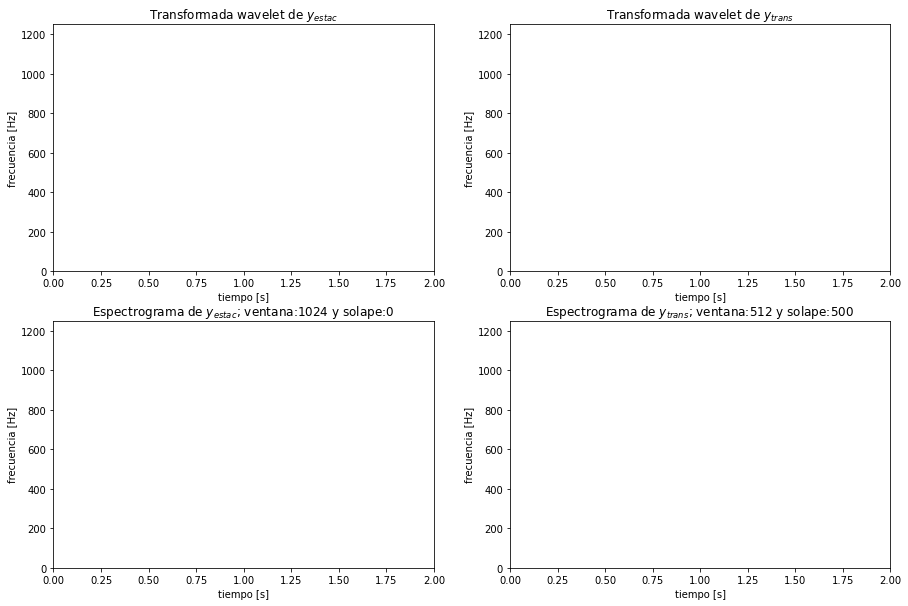

In [ ]:
#@title Celda sin la solución; inténtalo, no vas a romper nada
##############################################################tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 100, 300, 700, 1000
# Primera señal: compuesta por 4 senos simultáneos (estacionaria)
y_estac = np.sin(2 * np.pi * frec1 * t) + np.sin(2 * np.pi * frec2 * t) + np.sin(2 * np.pi * frec3 * t) + np.sin(2 * np.pi * frec4 * t)
# Segunda señal: compuesta por 4 senos consecutivos (transitoria)
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Transformada de wavelet
escalas = np.linspace(3.2,72,100)
tipowavelet = 'morl'
#aux_cwt_estac = pywt.cwt()
#cwt_estac = aux_cwt_estac[0]
#frecs = aux_cwt_estac[1]
#aux_cwt_trans = pywt.cwt()
#cwt_trans = aux_cwt_trans[0]
#frecs = aux_cwt_trans[1]
# Gráficas:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
#X, Y = np.meshgrid(t, frecs)
#im = ax1.pcolormesh(X, Y, np.abs(cwt_estac))
#X, Y = np.meshgrid(t, frecs)
#im = ax2.pcolormesh(X, Y, np.abs(cwt_trans))
tamanyo_ventana3, solape_ventana3 = 1024, 0
tamanyo_ventana4, solape_ventana4 = 512, 500
# f, t, Sxx = signal.spectrogram(senyal, fs, window=signal.get_window('hann', tamanyo_ventana3), noverlap=solape_ventana3)
# ax3.pcolormesh(t, f, Sxx)
# f, t, Sxx = signal.spectrogram(senyal, fs, window=signal.get_window('hann', tamanyo_ventana4), noverlap=solape_ventana4)
# ax4.pcolormesh(t, f, Sxx)
ax1.set_title('Transformada wavelet de $y_{estac}$')
ax2.set_title('Transformada wavelet de $y_{trans}$')
ax3.set_title('Espectrograma de $y_{{estac}}$; ventana:{} y solape:{} '.format(tamanyo_ventana3, solape_ventana3))
ax4.set_title('Espectrograma de $y_{{trans}}$; ventana:{} y solape:{} '.format(tamanyo_ventana4, solape_ventana4))
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(0, 1250)
    ax.set_xlim(0, 2)
    ax.set_xlabel('tiempo [s]')
    ax.set_ylabel('frecuencia [Hz]')


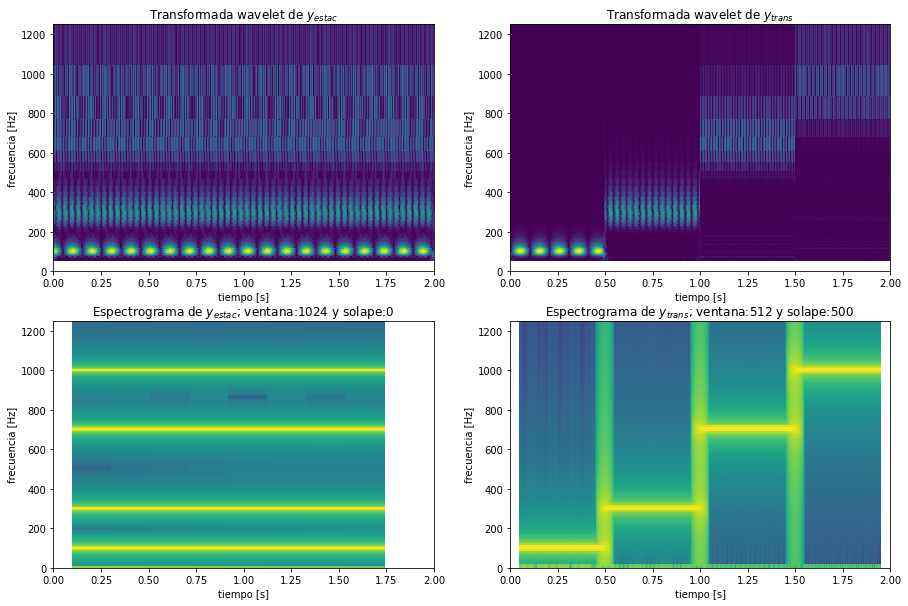

In [ ]:
#@title Celda con la solución
#############################
tmax = 2
N = 10000
fs = N / tmax
t = np.linspace(0, tmax, N)
frec1, frec2, frec3, frec4 = 100, 300, 700, 1000
# Primera señal: compuesta por 4 senos simultáneos (estacionaria)
y_estac = np.sin(2 * np.pi * frec1 * t) + np.sin(2 * np.pi * frec2 * t) + np.sin(2 * np.pi * frec3 * t) + np.sin(2 * np.pi * frec4 * t)
# Segunda señal: compuesta por 4 senos consecutivos (transitoria)
N1, N2, N3 = 2500, 5000, 7500
y1 = np.sin(2* np.pi * frec1 * t[0:N1]) # seno uno, primera parte
y2 = np.sin(2* np.pi * frec2 * t[N1:N2]) # seno dos, segunda parte
y3 = np.sin(2* np.pi * frec3 * t[N2:N3]) # seno tres, tercera parte
y4 = np.sin(2* np.pi * frec4 * t[N3:N]) # seno cuatro, cuarta parte
y_trans = np.concatenate([y1, y2, y3, y4])
# Transformada de wavelet
escalas = np.linspace(3.2,72,100)
tipowavelet = 'morl'
aux_cwt_estac = pywt.cwt(y_estac, escalas, tipowavelet, 1/fs)
cwt_estac = aux_cwt_estac[0]
frecs = aux_cwt_estac[1]
aux_cwt_trans = pywt.cwt(y_trans, escalas, tipowavelet, 1/fs)
cwt_trans = aux_cwt_trans[0]
frecs = aux_cwt_trans[1]
# Gráficas:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
X, Y = np.meshgrid(t, frecs)
im = ax1.pcolormesh(X, Y, np.abs(cwt_estac))
X, Y = np.meshgrid(t, frecs)
im = ax2.pcolormesh(X, Y, np.abs(cwt_trans))
tamanyo_ventana3, solape_ventana3 = 1024, 0
tamanyo_ventana4, solape_ventana4 = 512, 500
f, t, Sxx = sig.spectrogram(y_estac, fs, window=sig.get_window('hann', tamanyo_ventana3), noverlap=solape_ventana3)
ax3.pcolormesh(t, f, Sxx)
f, t, Sxx = sig.spectrogram(y_trans, fs, window=sig.get_window('hann', tamanyo_ventana4), noverlap=solape_ventana4)
ax4.pcolormesh(t, f, Sxx)
ax1.set_title('Transformada wavelet de $y_{estac}$')
ax2.set_title('Transformada wavelet de $y_{trans}$')
ax3.set_title('Espectrograma de $y_{{estac}}$; ventana:{} y solape:{} '.format(tamanyo_ventana3, solape_ventana3))
ax4.set_title('Espectrograma de $y_{{trans}}$; ventana:{} y solape:{} '.format(tamanyo_ventana4, solape_ventana4))
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(0, 1250)
    ax.set_xlim(0, 2)
    ax.set_xlabel('tiempo [s]')
    ax.set_ylabel('frecuencia [Hz]')


### Ejercicio 5.3: Determinación del régimen de giro de una máquina en funcionamiento transitorio

En ocasiones resulta interesante conocer el régimen de giro de una máquina.

Si, al calcularlo, no coincide el que se supone que debería ser o se observa una modificación con el paso del tiempo, quizá la máquina esté empezando a desviarse de su comportamiento normal y sea necesario llevar a cabo alguna tarea de mantenimiento preventivo.

A modo de ejemplo, en este ejercicio se pretende calcular el régimen de giro del motor que originó la señal la señal "ferrari355-freesound43484.wav" que se encuentra en la carpeta "sounds/tema04". Puesto que en un ejercicio anterior hemos descubierto que es una señal transitoria, vamos a utilizar el espectrograma:


La siguiente celda es nuestro punto de partida. Contiene la lectura de la señal y el cálculo del espectrograma de la señal:

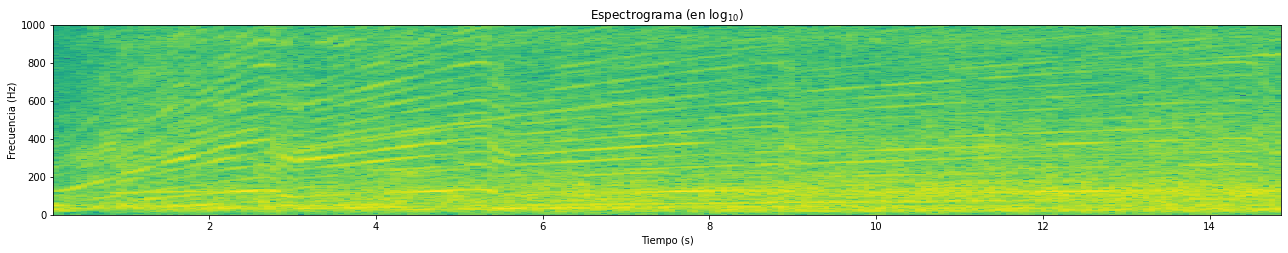

In [ ]:
#@title Identificación del régimen de giro de un MCIA a partir del ruido emitido
###############################
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema05/FerrariFF6.3V12.wav') # descarga el fichero de Internet
with open('FerrariFF6.3V12.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Lectura de un fichero de audio (en formato WAV)
fs, senyal = wavfile.read("FerrariFF6.3V12.wav")
if len(np.shape(senyal)) > 1:
    senyal = senyal[:, 0] # grabación en estéreo: nos quedamos con solo un canal
senyal = senyal.astype(np.float32, order='C') / 32768.0

fig = plt.figure(figsize=(22, 3.5))
ax1 = fig.add_subplot(1, 1, 1)
f, t, Sxx = sig.spectrogram(senyal, fs, window=sig.get_window('hann', 4096), noverlap=3000)
ax1.pcolormesh(t, f, Sxx)
ax1.set_xlim([t.min(), t.max()])
ax1.set_ylim([0, 1000])
ax1.set_title('Espectrograma (en $\mathrm{log_{10}}$)')
ax1.set_ylabel('Frecuencia (Hz)')
ax1.set_xlabel('Tiempo (s)');

**Análisis**

De la observación del espectrograma se detecta un contenido frecuencial alto en torno a los 200 Hz y múltiplos (armónicos) de esta frecuencia. Se detecta además que las frecuencias relevantes no son constantes con el tiempo (porque el régimen de giro del motor tampoco lo es).

**Continuación del ejercicio**

La idea ahora es calcular a qué frecuencias se da el valor máximo del espectrograma a lo largo del tiempo.


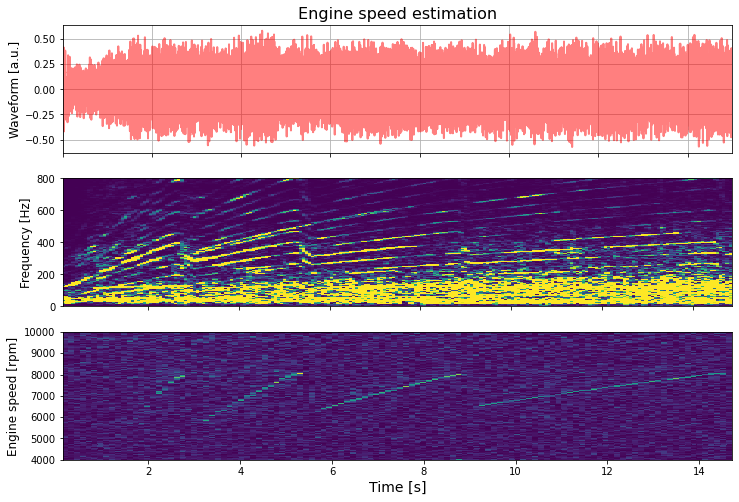

In [ ]:
#@title Visualization
# Fuente del audio: https://www.youtube.com/watch?v=USSrD7Y4qYA
# Figure and three axes
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax4 = fig.add_subplot(3, 1, 3)

# Audio waveform
time = np.linspace(0, len(senyal)/fs,len(senyal))
ax1.plot(time, senyal, lw=2, color=([1,0,0,0.5]))

# Spectrogram
f, t, Sxx = sig.spectrogram(senyal, fs, window=sig.get_window('hann', 4096), noverlap=3000)
pcm = ax2.pcolormesh(t, f, Sxx, vmin = 0, vmax = 0.00005)
#fig.colorbar(pcm, ax=ax2)

# define the analysis parameters
wlen = int(0.5*fs) #024*4                       # window length (recomended to be power of 2)
wlen = 4096
hop = int(wlen/2)                         # hop size (recomended to be power of 2)

# calculate the cepstrogram
win = sig.windows.hamming(wlen)
C, q, t2 = cepstrogram(senyal, win, hop, fs)

# some conditioning
C = C[q > 0.5e-3, :]              # ignore all cepstrum coefficients for 
                                  # quefrencies below 0.5 ms  
q = q[q > 0.5e-3]                 # ignore all quefrencies below 0.5 ms
q = q*1000                        # convert the quefrency to ms

z = 8
regimen = 1/(q/1000)*720/6
pcm = ax4.pcolormesh(t2, regimen, np.abs(C), vmin=0,vmax=0.15)
#fig.colorbar(pcm, ax=ax4)

ax1.grid()
ax1.set_xlim([time.min(), time.max()])
ax2.set_xlim([t.min(), t.max()])
ax2.set_ylim([0, 800])
ax4.set_ylim([4000,10000])
ax1.set_title('Engine speed estimation', fontsize=16)
ax1.set_ylabel('Waveform [a.u.]',fontsize=12)
ax2.set_ylabel('Frequency [Hz]',fontsize=12)
ax4.set_ylabel('Engine speed [rpm]',fontsize=12)
ax4.set_xlabel('Time [s]',fontsize=14)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
Audio(senyal,rate=fs)

**Instalación de librerías en WinPython**

Vamos a hacer uso ahora de una nueva librería que se usa mucho en el ámbito de la fonética y el reconocimiento de voz. Esta librería se llama [praat-parselmouth](https://parselmouth.readthedocs.io/en/stable/) (¿algún fan de la saga de Harry Potter?) y no viene instalada por defecto en WinPython. No pasa nada; ejecuta la celda siguiente y espera unos segundos a ver si se instala.

Una vez instalada, ya no es necesario volver a instalarla y, por tanto, no tendrás que ejecutar más veces dicha celda.


In [ ]:
#@title Celda para instalar la librería ParselMouth
import sys, subprocess
proceso = subprocess.call([sys.executable, '-m', 'pip', 'install', 'praat-parselmouth'])
if proceso == 0:
    print("¡Perfecto! La librería se ha instalado con éxito.")
else:
    print("¡Ups! Ha ocurrido un error al intentar instalar la librería. El error puede deberse a muchas cosas. Muchas veces es por una mala conexión a Internet. Revisa, a ver. Quizá Héctor te lo pueda solucionar.")


¡Perfecto! La librería se ha instalado con éxito.


In [ ]:
# Importamos la librería ParselMouth
import parselmouth

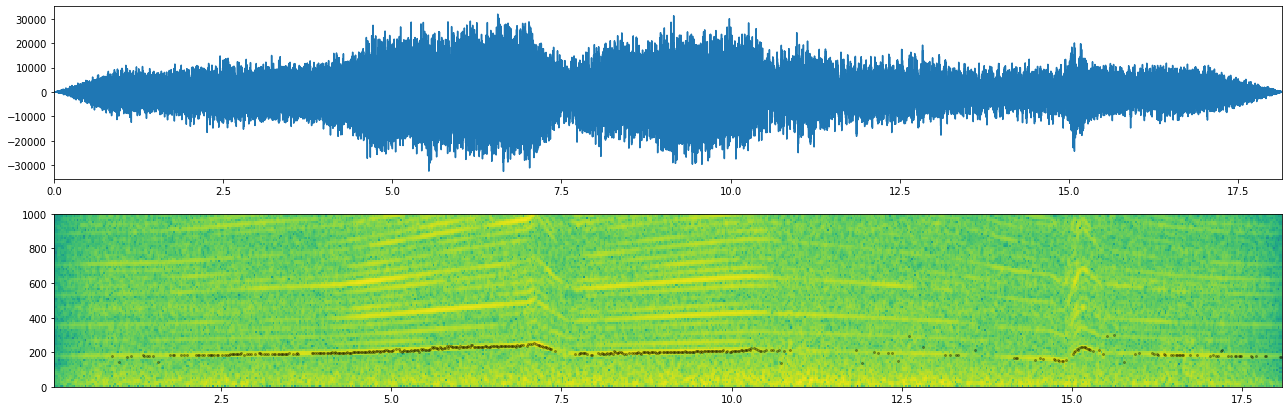

In [ ]:
#@title Algoritmo que detecta las frecuencias más relevantes en una señal en función del tiempo
# Para ello es necesario dar un rango de frecuencias (fmin, fmax) para ayudar a ese algoritmo
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/ferrari355-freesound43484.wav') # descarga el fichero de Internet
with open('ferrari355-freesound43484.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Lectura de un fichero de audio (en formato WAV)
fs, senyal = wavfile.read("ferrari355-freesound43484.wav")

# Creamos un objeto Sound de la librería ParselMouth
snd = parselmouth.Sound(senyal,fs)

# Creamos la figura y tres gráficos
fig = plt.figure(figsize=(22, 7))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

# Señal temporal
ax1.plot(snd.xs(), snd.values.T)
ax1.set_xlim([snd.xmin, snd.xmax])

# Espectrograma
f, t, Sxx = sig.spectrogram(senyal, fs, window=sig.get_window('hann', 4096), noverlap=3000)
ax2.pcolormesh(t, f, np.log10(Sxx))
ax2.set_xlim([t.min(), t.max()])
ax2.set_ylim([0, 1000])

# Identificación de las frecuencias predominantes en una señal
fmin, fmax = 130, 320 # rango de frecuencias donde el algoritmo va a buscar las predominantes
# Ayuda de la función to_pitch_ac ---> http://www.fon.hum.uva.nl/praat/manual/Sound__To_Pitch__ac____.html
PrimerArmonico = snd.to_pitch_ac(time_step=0.02, pitch_floor=fmin, max_number_of_candidates=2, voicing_threshold=0.1,
                        silence_threshold=0.0, pitch_ceiling=fmax, voiced_unvoiced_cost=0.14,
                        octave_cost=0.02, octave_jump_cost=5)
val_PrimerArmonico = PrimerArmonico.selected_array['frequency']
val_PrimerArmonico[val_PrimerArmonico==0] = np.nan
ax2.scatter(PrimerArmonico.xs(), val_PrimerArmonico, s=4, color=[0, 0, 0, 0.3])

**Análisis:**

Perfecto. Con ayuda de la librería ParselMouth, somos capaces de identificar relativamente bien el primer armónico del ruido producido por el motor.

**Continuación del ejercicio**

Se trata ahora de convertir esa frecuencia en régimen de giro. Para ello se debe conocer cuántos cilindros tiene el motor y el tipo de motor (2 tiempos o 4 tiempos).

Una simple [búsqueda](https://www.google.com/search?q=ferrari+355+%22number+of+cylinders%22) nos indica que es un motor de 4T y 8 cilindros.

**Relación entre régimen de giro y frecuencia en un Motor de Combustión Interna Alternativo (MCIA)**

La relación entre el ángulo girado por el cigüeñal y la velocidad angular cumple:
$$\theta \mathrm{(rad)} = \omega \mathrm{(rad/s)} \cdot t \mathrm{(s)} $$

y la velocidad angular expresada en revoluciones por minuto (que es una unidad más común al hablar de régimen de giro de un eje) se expresa según:
$$\omega \mathrm{(rad/s)} = N \mathrm{(rev/min)} \frac{2 \pi \mathrm{(rad)}}{1 \mathrm{(rev)}} \frac{1 \mathrm{(min)}}{60 \mathrm{(s)}} $$

por otro lado, la relación entre radianes y grados es:
$$\theta \mathrm{(rad)} = \alpha \mathrm{(grad)} \frac{2 \pi \mathrm{(rad)}}{360 \mathrm{(grad)}} $$

y combinando las tres expresiones anteriores llegamos a:
$$\alpha \mathrm{(grad)} \frac{2 \pi}{360} = N \mathrm{(rev/min)} \frac{2 \pi}{60} \cdot t $$

De aquí se puede despejar el régimen de giro y, sabiendo que un motor de 4 tiempos ha de girar dos vueltas (720 grados) para que todos los cilindros ($z$) hayan realizado un ciclo de funcionamiento y que, por tanto, existirá una combustión cada $720/z \mathrm{(grados)}$ se llega a la expresión buscada:
$$N \mathrm{(rev/min)} = \frac{\alpha \mathrm{(grad)}}{6 \, t \mathrm{(s)}} = \frac{720/z \mathrm{(grad)}}{6 \, T \mathrm{(s)}} = \frac{720 \, f \mathrm{(Hz)}}{6 \, z} $$

donde $T$ (o $f$) es el período (o la frecuencia) entre dos procesos de combustión consecutivos.

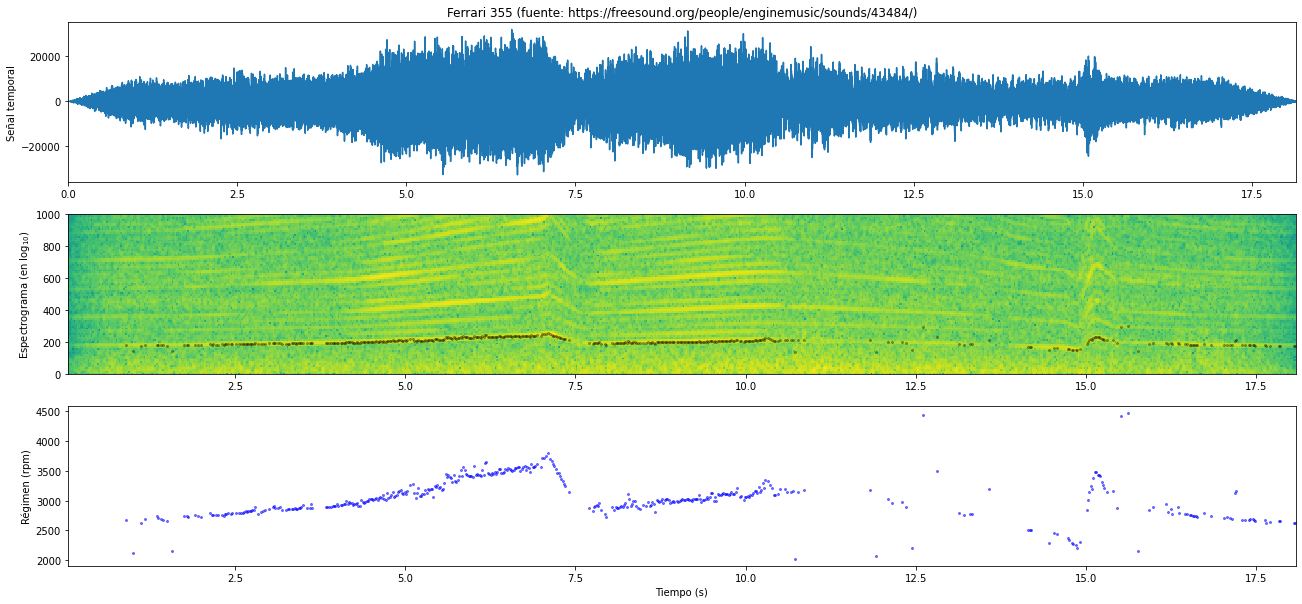

In [ ]:
#@title Identificación del régimen de giro de un MCIA a partir del ruido emitido
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema04/ferrari355-freesound43484.wav') # descarga el fichero de Internet
with open('ferrari355-freesound43484.wav','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
# Lectura de un fichero de audio (en formato WAV)
fs, senyal = wavfile.read("ferrari355-freesound43484.wav")

# Creamos un objeto Sound de la librería ParselMouth
snd = parselmouth.Sound(senyal,fs)

# Creamos la figura y tres gráficos
fig = plt.figure(figsize=(22, 10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

# Señal temporal
ax1.plot(snd.xs(), snd.values.T)
ax1.set_xlim([snd.xmin, snd.xmax])

# Espectrograma
f, t, Sxx = sig.spectrogram(senyal, fs, window=sig.get_window('hann', 4096), noverlap=3000)
ax2.pcolormesh(t, f, np.log10(Sxx))
ax2.set_xlim([t.min(), t.max()])
ax2.set_ylim([0, 1000])

# Identificación de las frecuencias predominantes en una señal
fmin, fmax = 130, 320
# Ayuda de la función to_pitch_ac ---> http://www.fon.hum.uva.nl/praat/manual/Sound__To_Pitch__ac____.html
PrimerArmonico = snd.to_pitch_ac(time_step=0.02, pitch_floor=fmin, max_number_of_candidates=2, voicing_threshold=0.1,
                        silence_threshold=0.0, pitch_ceiling=fmax, voiced_unvoiced_cost=0.14,
                        octave_cost=0.02, octave_jump_cost=5)
val_PrimerArmonico = PrimerArmonico.selected_array['frequency']
val_PrimerArmonico[val_PrimerArmonico==0] = np.nan
ax2.scatter(PrimerArmonico.xs(), val_PrimerArmonico, s=4, color=[0, 0, 0, 0.3])
# Relación entre frecuencia y régimen de giro en un MCIA de 4T, teniendo en cuenta el número de cilindros (z):
# T(s) = 720/z(º) / 6N(rpm) ; f(Hz) = 1/T
# y despejando:
# N(rpm) = 720 f(Hz) / 6z
ncil = 8 # https://www.google.com/search?q=ferrari+355+%22number+of+cylinders%22
ene = val_PrimerArmonico*720/6/ncil
ax3.scatter(PrimerArmonico.xs(), ene, s=4, color=[0, 0, 1, 0.5])
ax3.set_xlim([t.min(), t.max()])
ax1.set_title('Ferrari 355 (fuente: https://freesound.org/people/enginemusic/sounds/43484/)')
ax1.set_ylabel('Señal temporal')
ax2.set_ylabel('Espectrograma (en $\mathrm{log_{10}}$)')
ax3.set_ylabel('Régimen (rpm)')
ax3.set_xlabel('Tiempo (s)');

**Análisis:**

En general el resultado es aceptable pero el algoritmo no es perfecto. Algunos detalles a tener en cuenta:

- Hay tramos donde el algoritmo detecta que hay silencio. Se puede intentar aumentar la sensibilidad pero quizá estropee otras zonas.
- Hay una zona donde el algoritmo ha detectado que otro armónico es más relevante que el que estamos buscando y existe un cambio brusco en la frecuencia de interés.
- Siempre es necesario entender el fenómeno que se está analizando y los resultados del procesado de señales para evitar identificar problemas donde no los hay y al contrario.

### ¿Qué debes haber aprendido al hacer los ejercicios?

- A realizar espectrogramas.
- A comprender la importancia en la elección del tamaño de ventana.
- A realizar transformadas de wavelet.
- A comprender cuándo es más interesante una transformada de wavelet que un espectrograma.
- A detectar la separación entre frecuencias equiespaciadas en un espectro mediante el uso del cepstro.
- A eliminar ecos mediante el uso del cepstro.
- A identificar regímenes de giro en máquinas rotatorias en funcionamiento transitorio a partir del ruido que hacen.

## Fin del tema

## Material adicional

### Anexo 1
La siguiente pregunta hace referencia a la definición del cepstro. Es cierto que en algunos libros aparece de una manera ($F^{−1}\left( ln|F(x[n])| \right)$) y en otros de otra ($F\left( ln|F(x[n])| \right)$).

¿Cuál es la correcta? Bien, la siguiente celda muestra que ambas son equivalentes.


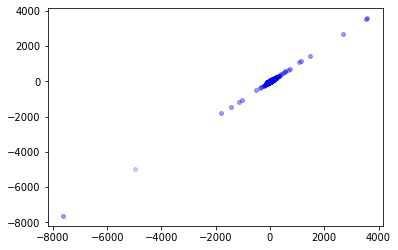

In [ ]:
#@title Duda clásica: hay dos formas equivalentes de calcular el cepstro real
# https://dsp.stackexchange.com/questions/44027/cepstrum-calculus-disambiguation
# En la literatura se encuentran estas dos expresiones para el cálculo del cepstro real
# Esta celda demuestra que son equivalentes
# Descarga en el ordenador el audio
fichin = urllib.request.urlopen('https://hcliment.webs.upv.es/docencia/dar/sounds/tema05/signalconeco.dat') # descarga el fichero de Internet
with open('signalconeco.dat','wb') as fichout:
    fichout.write(fichin.read()) # guarda el fichero en el ordenador
dat = pd.read_csv('signalconeco.dat', skiprows=0, skipfooter=0, sep='\t', dtype=float, engine='python')
h = dat['valor'].values
ceps1 = np.fft.ifft(np.log(np.abs(np.fft.fft(h))))*len(h).real
ceps2 = np.fft.fft(np.log(np.abs(np.fft.fft(h)))).real
plt.scatter(ceps1,ceps2,marker='o',s=15,color=([0,0,1,0.2]));


### Anexo 2

La siguiente celda demuestra que:

- La relación de convolución entre señales temporales: $y(t) = h(t) * x(t)$
- La relación multiplicativa entre espectros: $Y(f) = H(f) \cdot X(f)$
- La relación aditiva entre cepstros: $\hat{y}(\tau) = \hat{h}(\tau) + \hat{x}(\tau)$


Tiempo entre impactos = 0.80 s. Frecuencia de muestreo = 20608.00 Hz


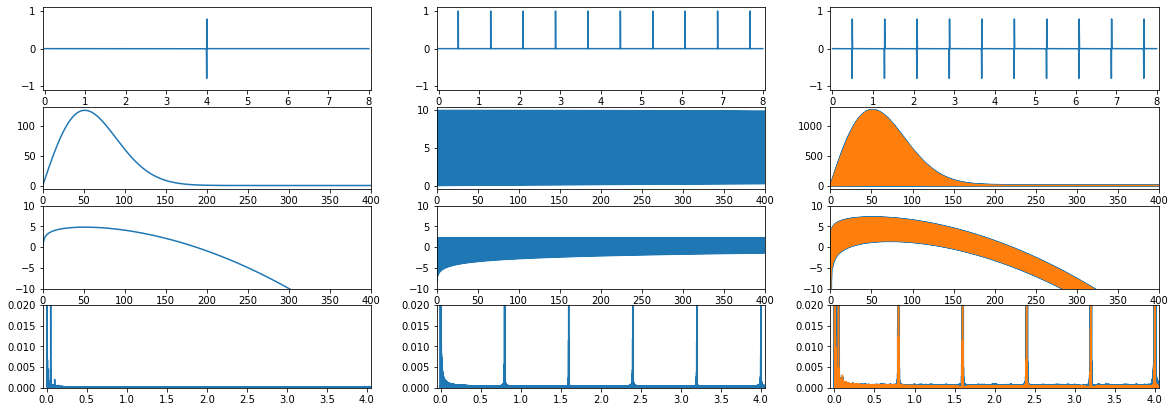

In [ ]:
#@title Señales en tiempo, frecuencia (espectro) y cuefrencia (cepstro)
tipos = ['morl', 'mexh', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8']
fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(4,3,1)
ax2 = fig.add_subplot(4,3,2)
ax3 = fig.add_subplot(4,3,3)
ax4 = fig.add_subplot(4,3,4)
ax5 = fig.add_subplot(4,3,5)
ax6 = fig.add_subplot(4,3,6)
ax7 = fig.add_subplot(4,3,7)
ax8 = fig.add_subplot(4,3,8)
ax9 = fig.add_subplot(4,3,9)
ax10 = fig.add_subplot(4,3,10)
ax11 = fig.add_subplot(4,3,11)
ax12 = fig.add_subplot(4,3,12)
wav = pywt.ContinuousWavelet(tipos[1])
s_imp, x = pywt.integrate_wavelet(wav, precision=10)
padleft = len(s_imp) * 80
padright = len(s_imp) * 80
s_imp = np.concatenate([np.zeros(padleft),s_imp*1.50,np.zeros(padright)])
N = len(s_imp)
tr_imp = np.zeros(N)
Nimp = 10 # número de impactos en la señal
espacio_imp = int(N/Nimp) # separación entre impactos
for k in range(10000,N,espacio_imp):
  tr_imp[k] = 1
tmax = 8
fs = N / tmax
tiempo = np.linspace(0,tmax,N)
y = np.convolve(s_imp, tr_imp,  mode='same')
STD_n= 0.01
noise=np.random.normal(0, STD_n, y.shape[0])
y = y # + noise
ax1.plot(tiempo, s_imp)
ax2.plot(tiempo, tr_imp)
ax3.plot(tiempo, y)
for ax in [ax1, ax2, ax3]:
  ax.set_xlim([-0.05,8.05])
  ax.set_ylim([-1.1,1.1])
# Transformadas de Fourier
S_IMP = np.fft.fft(s_imp)
TR_IMP = np.fft.fft(tr_imp)
Y = np.fft.fft(y)
Y2 = S_IMP * TR_IMP
frec = np.fft.fftfreq(N, 1/fs)
ax4.plot(frec[0:N//2], np.abs(S_IMP[0:N//2]))
ax5.plot(frec[0:N//2], np.abs(TR_IMP[0:N//2]))
ax6.plot(frec[0:N//2], np.abs(Y[0:N//2]),lw=3)
ax6.plot(frec[0:N//2], np.abs(Y2[0:N//2]))
for ax in [ax4, ax5, ax6]:
  ax.set_xlim([0,400])
# Log Power Spectrum
# ceps = np.fft.ifft(np.log(np.abs(spectrum))).real
LP_S_IMP = np.log(np.abs(S_IMP))
LP_TR_IMP = np.log(np.abs(TR_IMP))
LP_Y = np.log(np.abs(Y))
LP_Y2 = LP_S_IMP + LP_TR_IMP
ax7.plot(frec[0:N//2], LP_S_IMP[0:N//2])
ax8.plot(frec[0:N//2], LP_TR_IMP[0:N//2])
ax9.plot(frec[0:N//2], LP_Y[0:N//2],lw=3)
ax9.plot(frec[0:N//2], LP_Y2[0:N//2])
for ax in [ax7, ax8, ax9]:
  ax.set_xlim([0,400])
  ax.set_ylim([-10,10])
# Cepstro
s_imp_hat = np.fft.ifft(LP_S_IMP).real
tr_imp_hat = np.fft.ifft(LP_TR_IMP).real
y_hat = np.fft.ifft(LP_Y).real
y_hat2 = s_imp_hat + tr_imp_hat
ax10.plot(tiempo, np.abs(s_imp_hat))
ax11.plot(tiempo, np.abs(tr_imp_hat))
ax12.plot(tiempo, np.abs(y_hat),lw=3)
ax12.plot(tiempo, np.abs(y_hat2))
for ax in [ax10, ax11, ax12]:
  ax.set_xlim([-0.05,4.05])
  ax.set_ylim([0,0.02])
print('Tiempo entre impactos = {:.2f} s. Frecuencia de muestreo = {:.2f} Hz'.format(espacio_imp/fs, fs))
Audio(y,rate=fs)

**Análisis**

- La primera fila de gráficas corresponde a las señales $x(t)$, $h(t)$, $y(t)$. En la figura de la derecha se ha calculado $y(t)$ como convolución de $x(t)$, $h(t)$, es decir: $y(t) = x(t) * h(t)$, donde $*$ es el producto de convolución.
- La segunda fila corresponde a sus espectros: $X(f)$, $H(f)$, $Y(f)$. En la figura de la derecha hay dos cálculos de $Y(f)$:
    - $Y(f)$ calculada como $F(y(t))$
    - $Y(f)$ calculada como $X(f) \cdot H(f)$
    - Se observa que coinciden
- La tercera fila es equivalente a la segunda pero tomando logaritmos
- La cuarta fila corresponde a los cepstros. En la figura de la derecha hay dos cálculos de $\hat{y}(\tau)$:
    - $\hat{y}(\tau)$ calculada como $F^{-1}(log(abs(F(y))))$
    - $\hat{y}(\tau)$ calculada como $\hat{h}(\tau) + \hat{x}(\tau)$
    - Se observa que coinciden

### Anexo 3

Ejemplos con señales [chirp](https://en.wikipedia.org/wiki/Chirp)

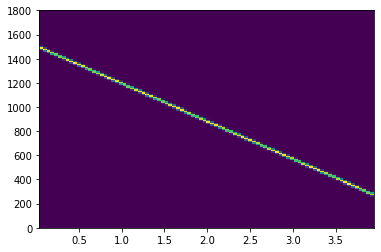

In [ ]:
#@title Espectrograma de un chirp lineal
fs = 7200
T = 4
t = np.arange(0, int(T*fs)) / fs
w = sig.chirp(t, f0=1500, f1=250, t1=T, method='linear')
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
tamanyo_ventana = 576
solape_ventana = 256
#f1, t1, Sxx1 = sig.spectrogram(w, fs, nperseg=256, nfft=576)
f1, t1, Sxx1 = sig.spectrogram(w, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax1.pcolormesh(t1, f1, Sxx1)
ax1.set_ylim([0,1800]);

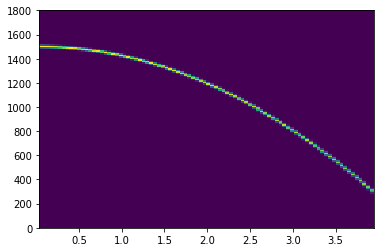

In [ ]:
#@title Espectrograma de un chirp cuadrático
fs = 7200
T = 4
t = np.arange(0, int(T*fs)) / fs
w = sig.chirp(t, f0=1500, f1=250, t1=T, method='quadratic')
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
tamanyo_ventana = 576
solape_ventana = 256
#f1, t1, Sxx1 = sig.spectrogram(w, fs, nperseg=256, nfft=576)
f1, t1, Sxx1 = sig.spectrogram(w, fs, window=sig.get_window('hann', tamanyo_ventana), noverlap=solape_ventana)
ax1.pcolormesh(t1, f1, Sxx1)
ax1.set_ylim([0,1800]);